# Case Study

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

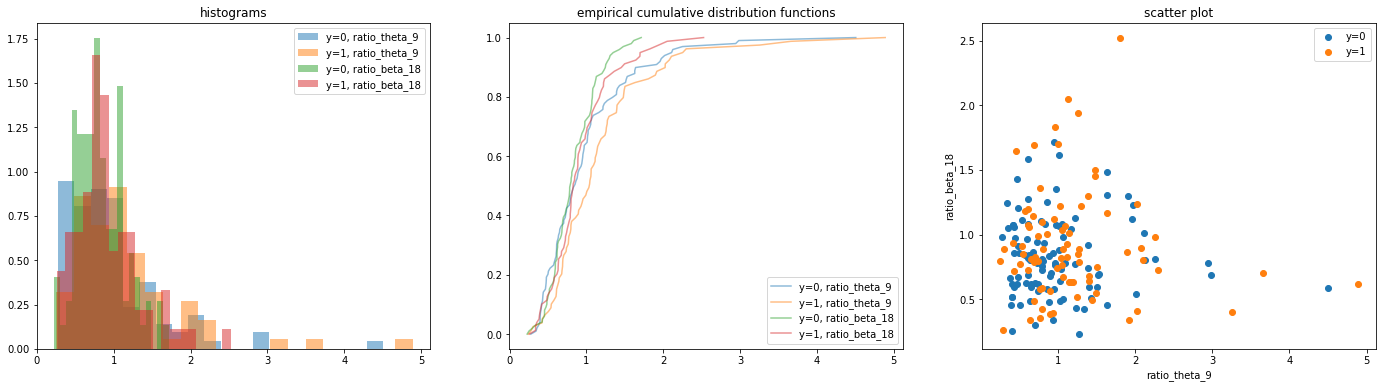

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

### Common Imports

In [4]:
# Imports for required packages
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest

from sklearn.svm import SVC

from numpy import mean
from numpy import std

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [5]:
# Creat CV data set 
kf = KFold(n_splits=18)
level2_kf = KFold(n_splits=17)

# Classifiers
model_lr = LogisticRegression(class_weight='balanced', max_iter=10000)
model_svm = SVC(kernel='linear')

In [6]:
import pandas as pd

columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (StD)', 'Precision', 'Recall', 'Specificity', 'Sensitivity']

no_feature_selection_scores_df = pd.DataFrame(columns = columns)
no_feature_selection_scores_df['Classifier'] = ['Logistic Regression', 'Linear SVM']
no_feature_selection_scores_df = no_feature_selection_scores_df.set_index('Classifier')

embed_scores_df = pd.DataFrame(columns = columns)
embed_scores_df['Classifier'] = ['Logistic Regression', 'Linear SVM']
embed_scores_df = embed_scores_df.set_index('Classifier')

wrapper_scores_df = pd.DataFrame(columns = columns)
wrapper_scores_df['Classifier'] = ['Logistic Regression', 'Linear SVM']
wrapper_scores_df = wrapper_scores_df.set_index('Classifier')

filter_scores_df = pd.DataFrame(columns = columns)
filter_scores_df['Classifier'] = ['Logistic Regression', 'Linear SVM']
filter_scores_df = filter_scores_df.set_index('Classifier')

In [7]:
def calculate_measures_folds(cm_folds):
    accuracy_folds = list()

    tp, fn, fp, tn = 0, 0, 0, 0

    for cm in cm_folds:
        if cm.shape == (1,1):
            tp = cm[0, 0]
        else:
            tp, fn, fp, tn = cm.ravel()

        total = tp + fn + fp + tn

        accuracy = (tp + tn) / total

        accuracy_folds.append(accuracy)
    
    return accuracy_folds

In [8]:
def calculate_measures(cm_folds):
    final_cm = np.array([[0, 0],
                         [0, 0]])

    for cm in cm_folds:
        if cm.shape == (1,1):
            final_cm[0, 0] += cm[0, 0]
        else:
            final_cm += cm

    tp, fn, fp, tn = final_cm.ravel()
    total = tp + fn + fp + tn

    accuracy = (tp + tn) / total
    precision = tp / (tp + fp)
    sensitivity = recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    return accuracy, precision, recall, specificity, sensitivity

## Leave-One-Subject Cross Validation

For each classification model ran - with or without Feature selection - we use KFold and split the data in 18 groups sequentially. The data is kept sequential to ensure that each group has the data related to one subject/patient as required by our experiment.

### Why this type of cross validation?

The Leave-One-Subject cross validation is done to ensure that the feature selection is applied only on the train data and the test data remains unknown and does not contribute to the best features to be selected. Not only this, but this method also ensures that the classifier predicts on "unseen" data, which helps us test and verify the performance of the trained model.

##  

# Training the Classifiers without Feature Engineering (Using leave one subject cross validation)

## Part 1 - Model training and test 
## a. Logistic Regression

In [9]:
# Performance measure information
cm_folds = list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model_lr.fit(X_train, y_train)

    # Test the model
    y_predicted = model_lr.predict(X_test)
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

### a. i) Calculating performance measures

In [10]:
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

no_feature_selection_scores_df.loc['Logistic Regression'].iat[0] = accuracy
no_feature_selection_scores_df.loc['Logistic Regression'].iat[1] = accuracy_std
no_feature_selection_scores_df.loc['Logistic Regression'].iat[2] = precision
no_feature_selection_scores_df.loc['Logistic Regression'].iat[3] = recall
no_feature_selection_scores_df.loc['Logistic Regression'].iat[4] = specificity
no_feature_selection_scores_df.loc['Logistic Regression'].iat[5] = sensitivity

### a. ii) Visualisation of accuracy for each fold

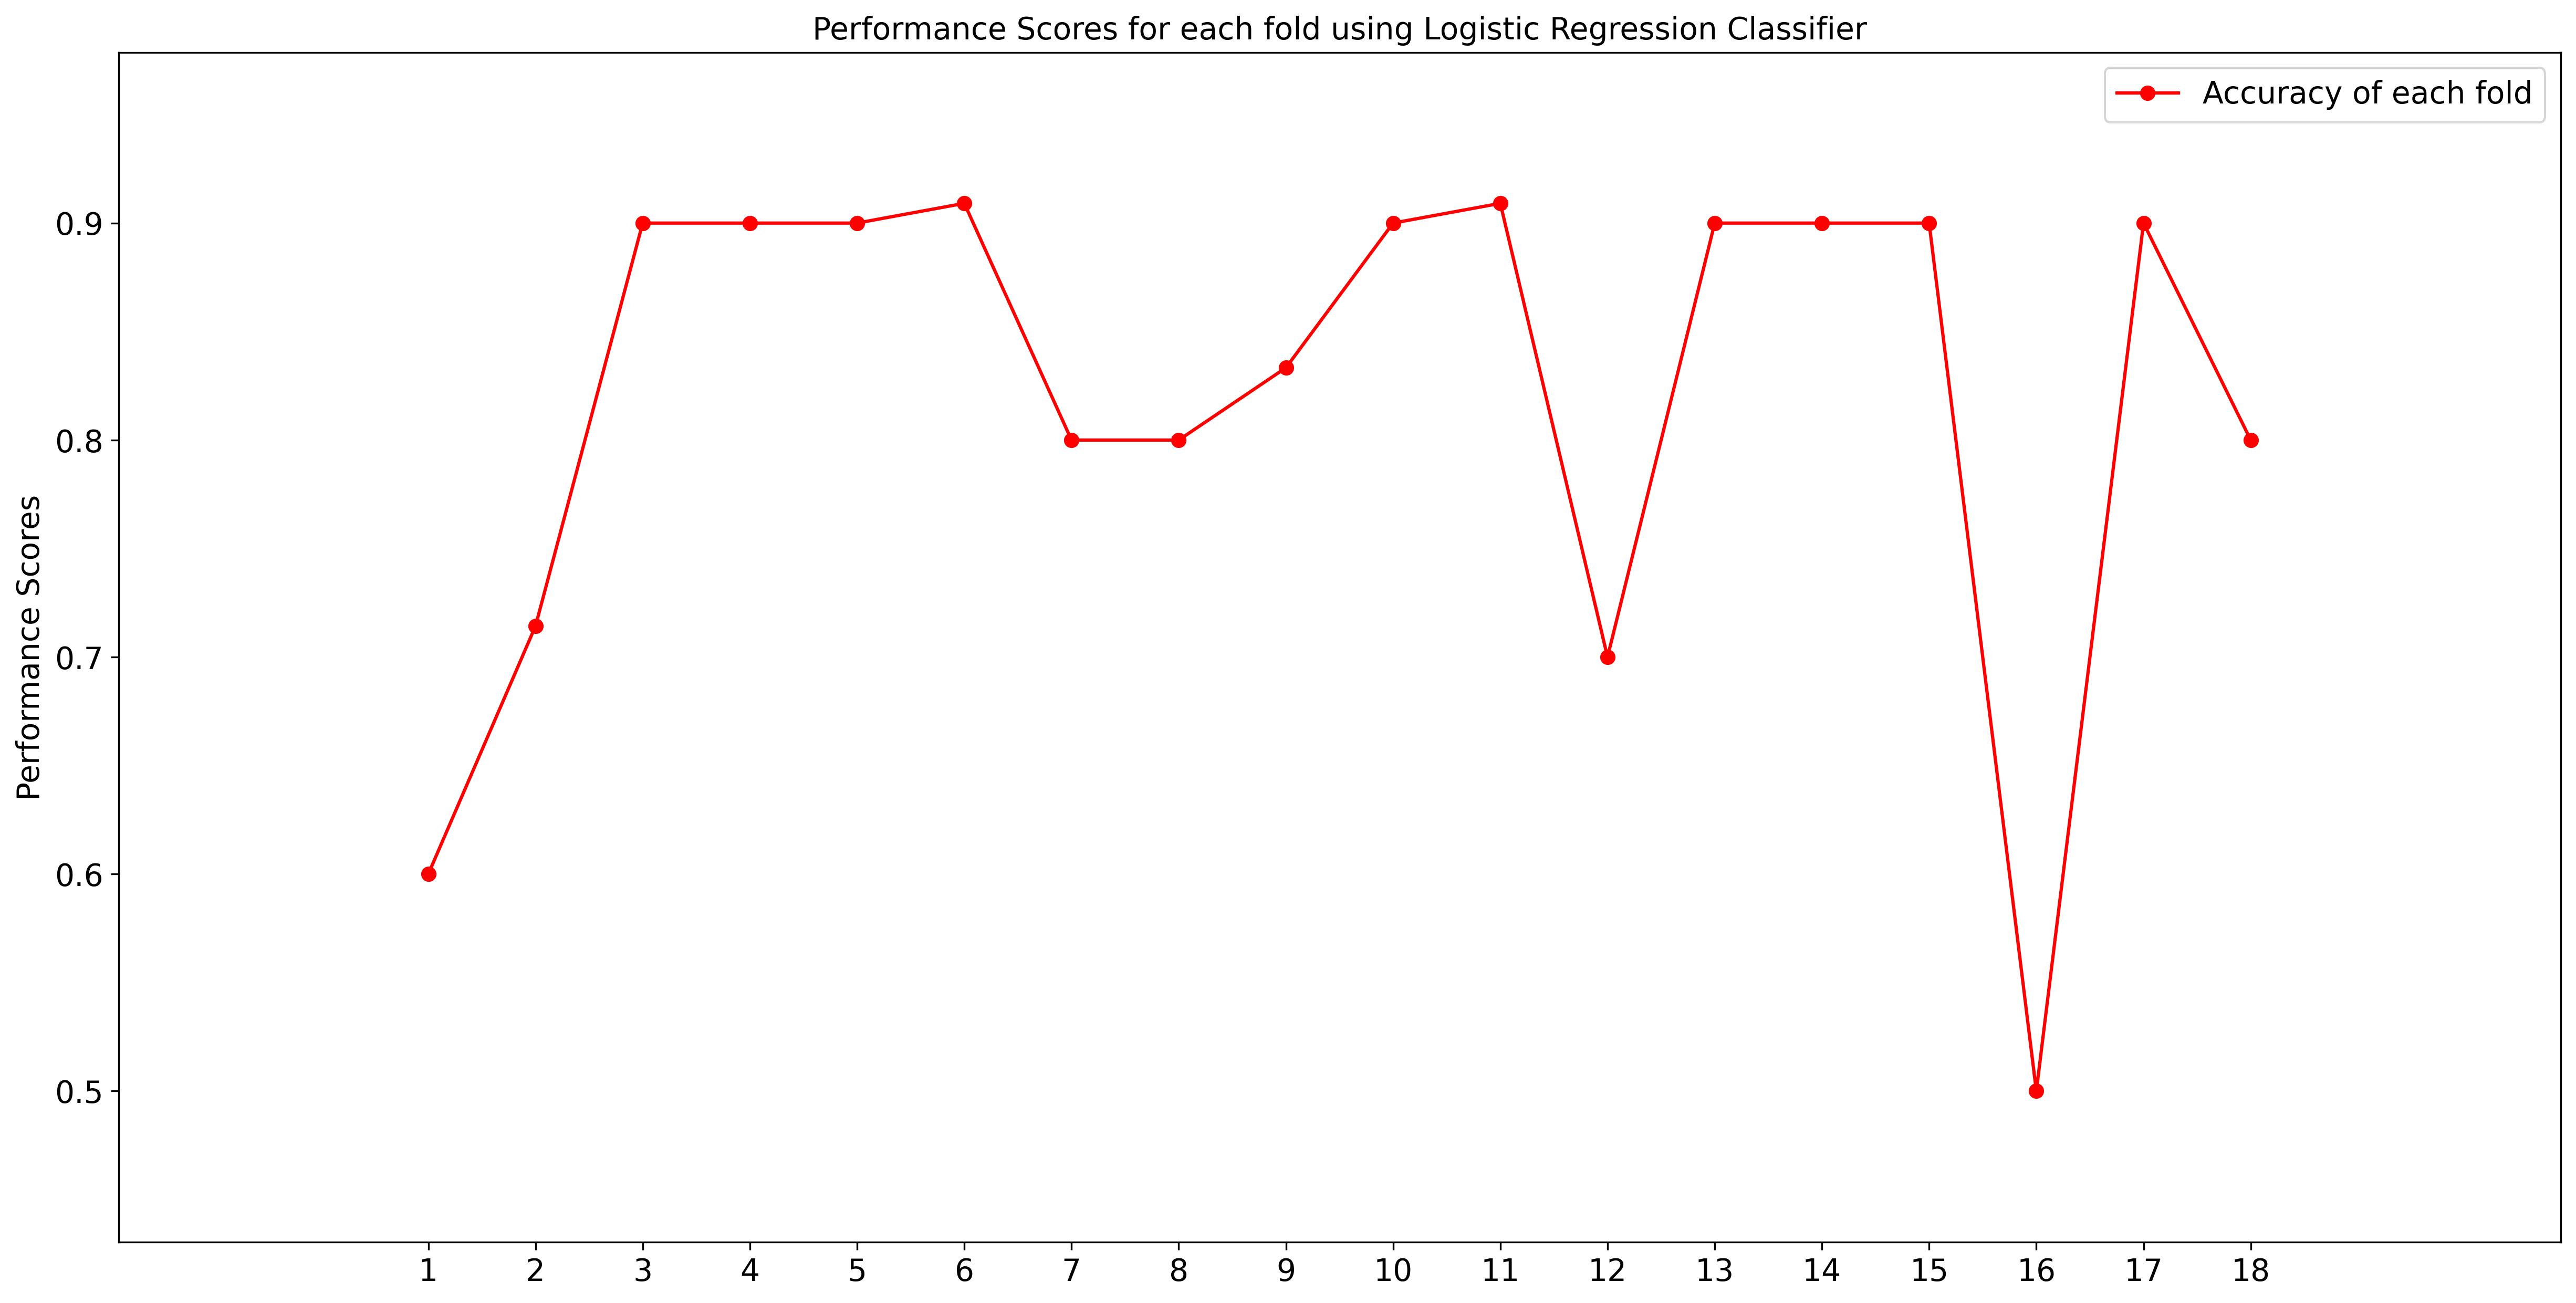

In [11]:
folds = list(range(1, 19))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using Logistic Regression Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

plt.show()

## b. Linear SVM

In [12]:
# Performance measure information
cm_folds = list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model_svm.fit(X_train, y_train)
    
    # Test the model
    y_predicted = model_svm.predict(X_test)
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

### b. i) Calculating performance measures

In [13]:
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

no_feature_selection_scores_df.loc['Linear SVM'].iat[0] = accuracy
no_feature_selection_scores_df.loc['Linear SVM'].iat[1] = accuracy_std
no_feature_selection_scores_df.loc['Linear SVM'].iat[2] = precision
no_feature_selection_scores_df.loc['Linear SVM'].iat[3] = recall
no_feature_selection_scores_df.loc['Linear SVM'].iat[4] = specificity
no_feature_selection_scores_df.loc['Linear SVM'].iat[5] = sensitivity

### b. ii) Visualisation of accuracy for each fold

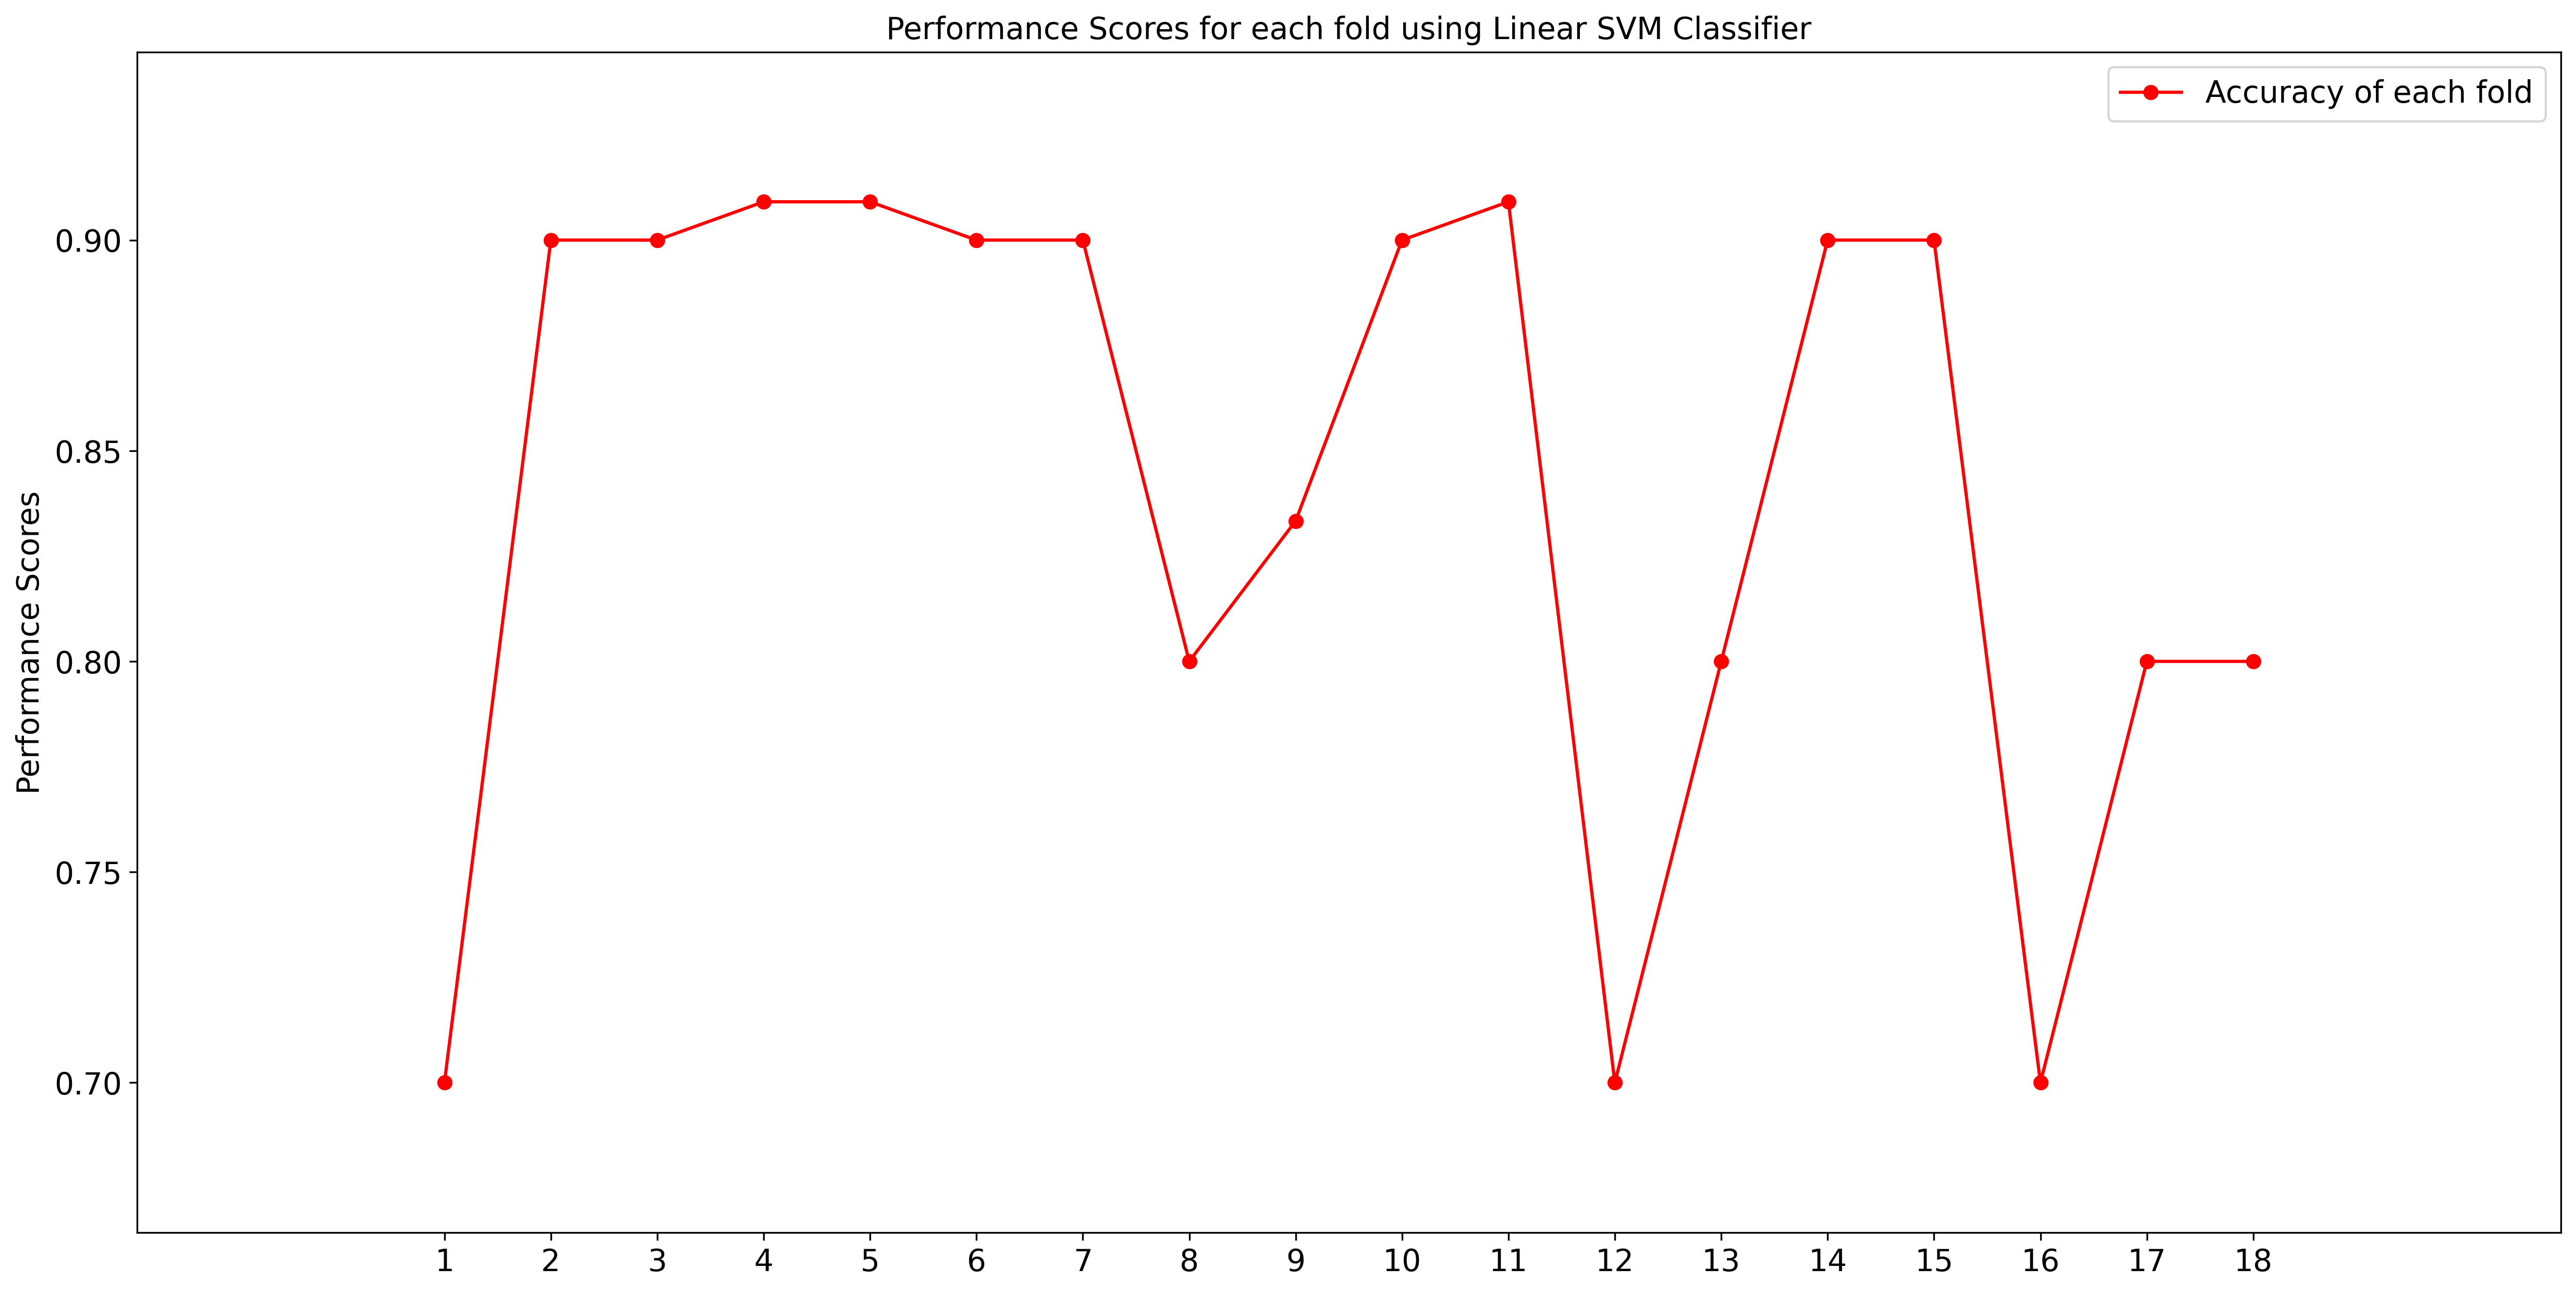

In [14]:
folds = list(range(1, 19))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using Linear SVM Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

plt.show()

## Part 2 - Performance Evaluation 
## Performance comparison considering all features

In [15]:
no_feature_selection_scores_df

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.855556,0.116625,0.875,0.890909,0.8,0.890909
Linear SVM,0.872222,0.076257,0.894309,0.916667,0.783333,0.916667


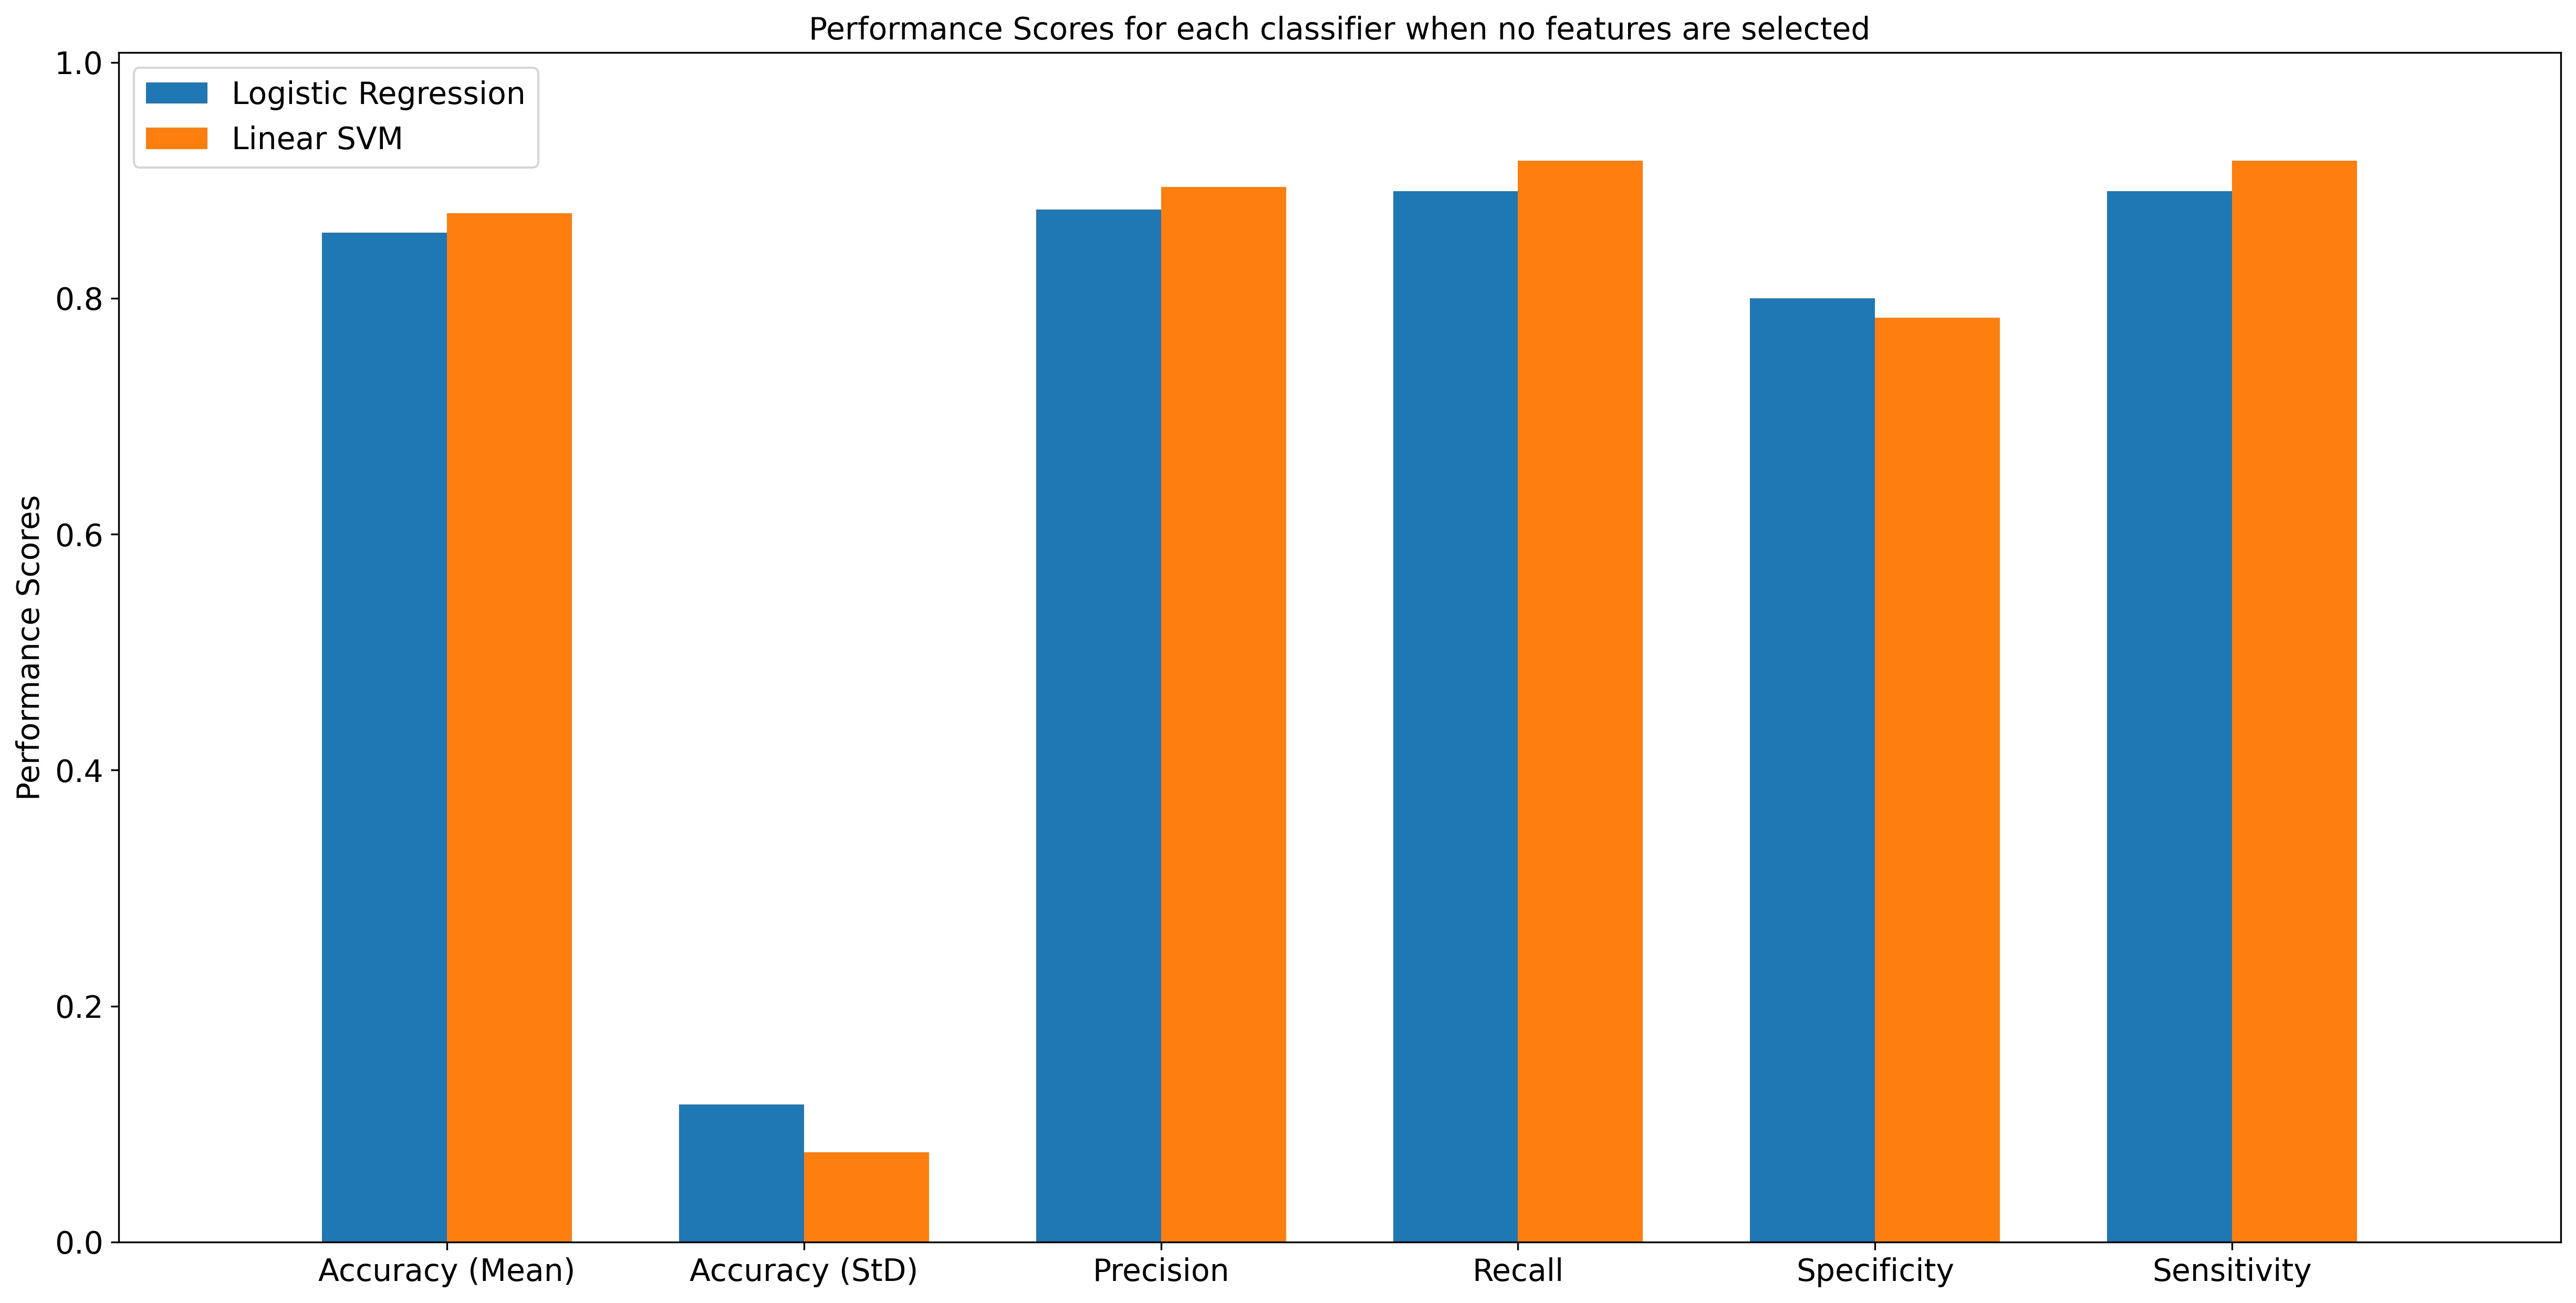

In [16]:
labels = list(embed_scores_df.columns)
lr_scores = no_feature_selection_scores_df.loc['Logistic Regression'].tolist()
svm_scores = no_feature_selection_scores_df.loc['Linear SVM'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, svm_scores, width, label='Linear SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each classifier when no features are selected', fontsize=14)
ax.set_xticks(x) # values
ax.set_xticklabels(labels) # labels
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.1)

plt.show()

The above plot marks 5 mean performance scores - accuracy, precision, Recall, Specificity and Sensitivity (same as Recall) across each fold run between the 2 classifiers used. Based on the results displayed, it is easy to infer that both classifiers performed similarly (in terms of accuracy). When training the models, using all 432 features across 18 folds, 'Linear SVM' Classification model shows to have just slightly better accuracy and precision.

#  

# Feature Engineering and Classification

For this case study, we have chosen 3 methods for feature selection - 
1. Embedded Method (L1 or L2 Regularization)
2. Wrapper Method (Feature Elimination)
3. Filtering Method (Rank features by relevance)

and, 

2 models for training and testing for classification - 
1. Logistic Regression
2. Linear SVM

For each Feature selection and corresponding training of classifier, we implement the following steps - 
1. Using KFold, split data into 18 equal sets of data 
2. Using for loop, iterate through each combination of 17 vs 1 subjects' data, where the data points of 17 subjects are considered for training, and the 1 subject is the unseen data to be tested to measure performance.
3. Now in each iteration (fold), we pass the training data to the feature selection model to get the best selected features. In this step, we again apply cross-validation by splitting the training data in 16 vs 1 subjects' data and pass this KFold object to the feature selection model for results.
4. Based the feature selection results, we get the reduced data and use it to train the Classifiers (listed above), and predict the values for the test data.
5. Comparing the predicted results against the true values, we compute the confusion matrix for the fold and save it (to be used later to compute mean performance scores)

Once all folds are run, we sum all the confusion matrices and derive the mean scores for evaluation and comparison.

## 1. Embedded Method (Lasso Regression - L1 Regularization)

### Part 1 - Model training and testing
### a. Using Logistic Regression as Classifier

In [17]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Feature Selection
    lasso_feature_selection = LassoCV(
        cv=level2_kf, 
        max_iter=10000, 
        random_state=42, 
        selection='random'
    ).fit(X_train, y_train)
    
    selected_feature_index = np.where(lasso_feature_selection.coef_!=0)[0]
    selected_features_folds.append(selected_feature_index.shape[0])
    
    # Train the model
    model_lr.fit(X_train[:, selected_feature_index], y_train)

    # Test the model
    y_predicted = model_lr.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### a. i) Visualisation of Performance scores for each fold

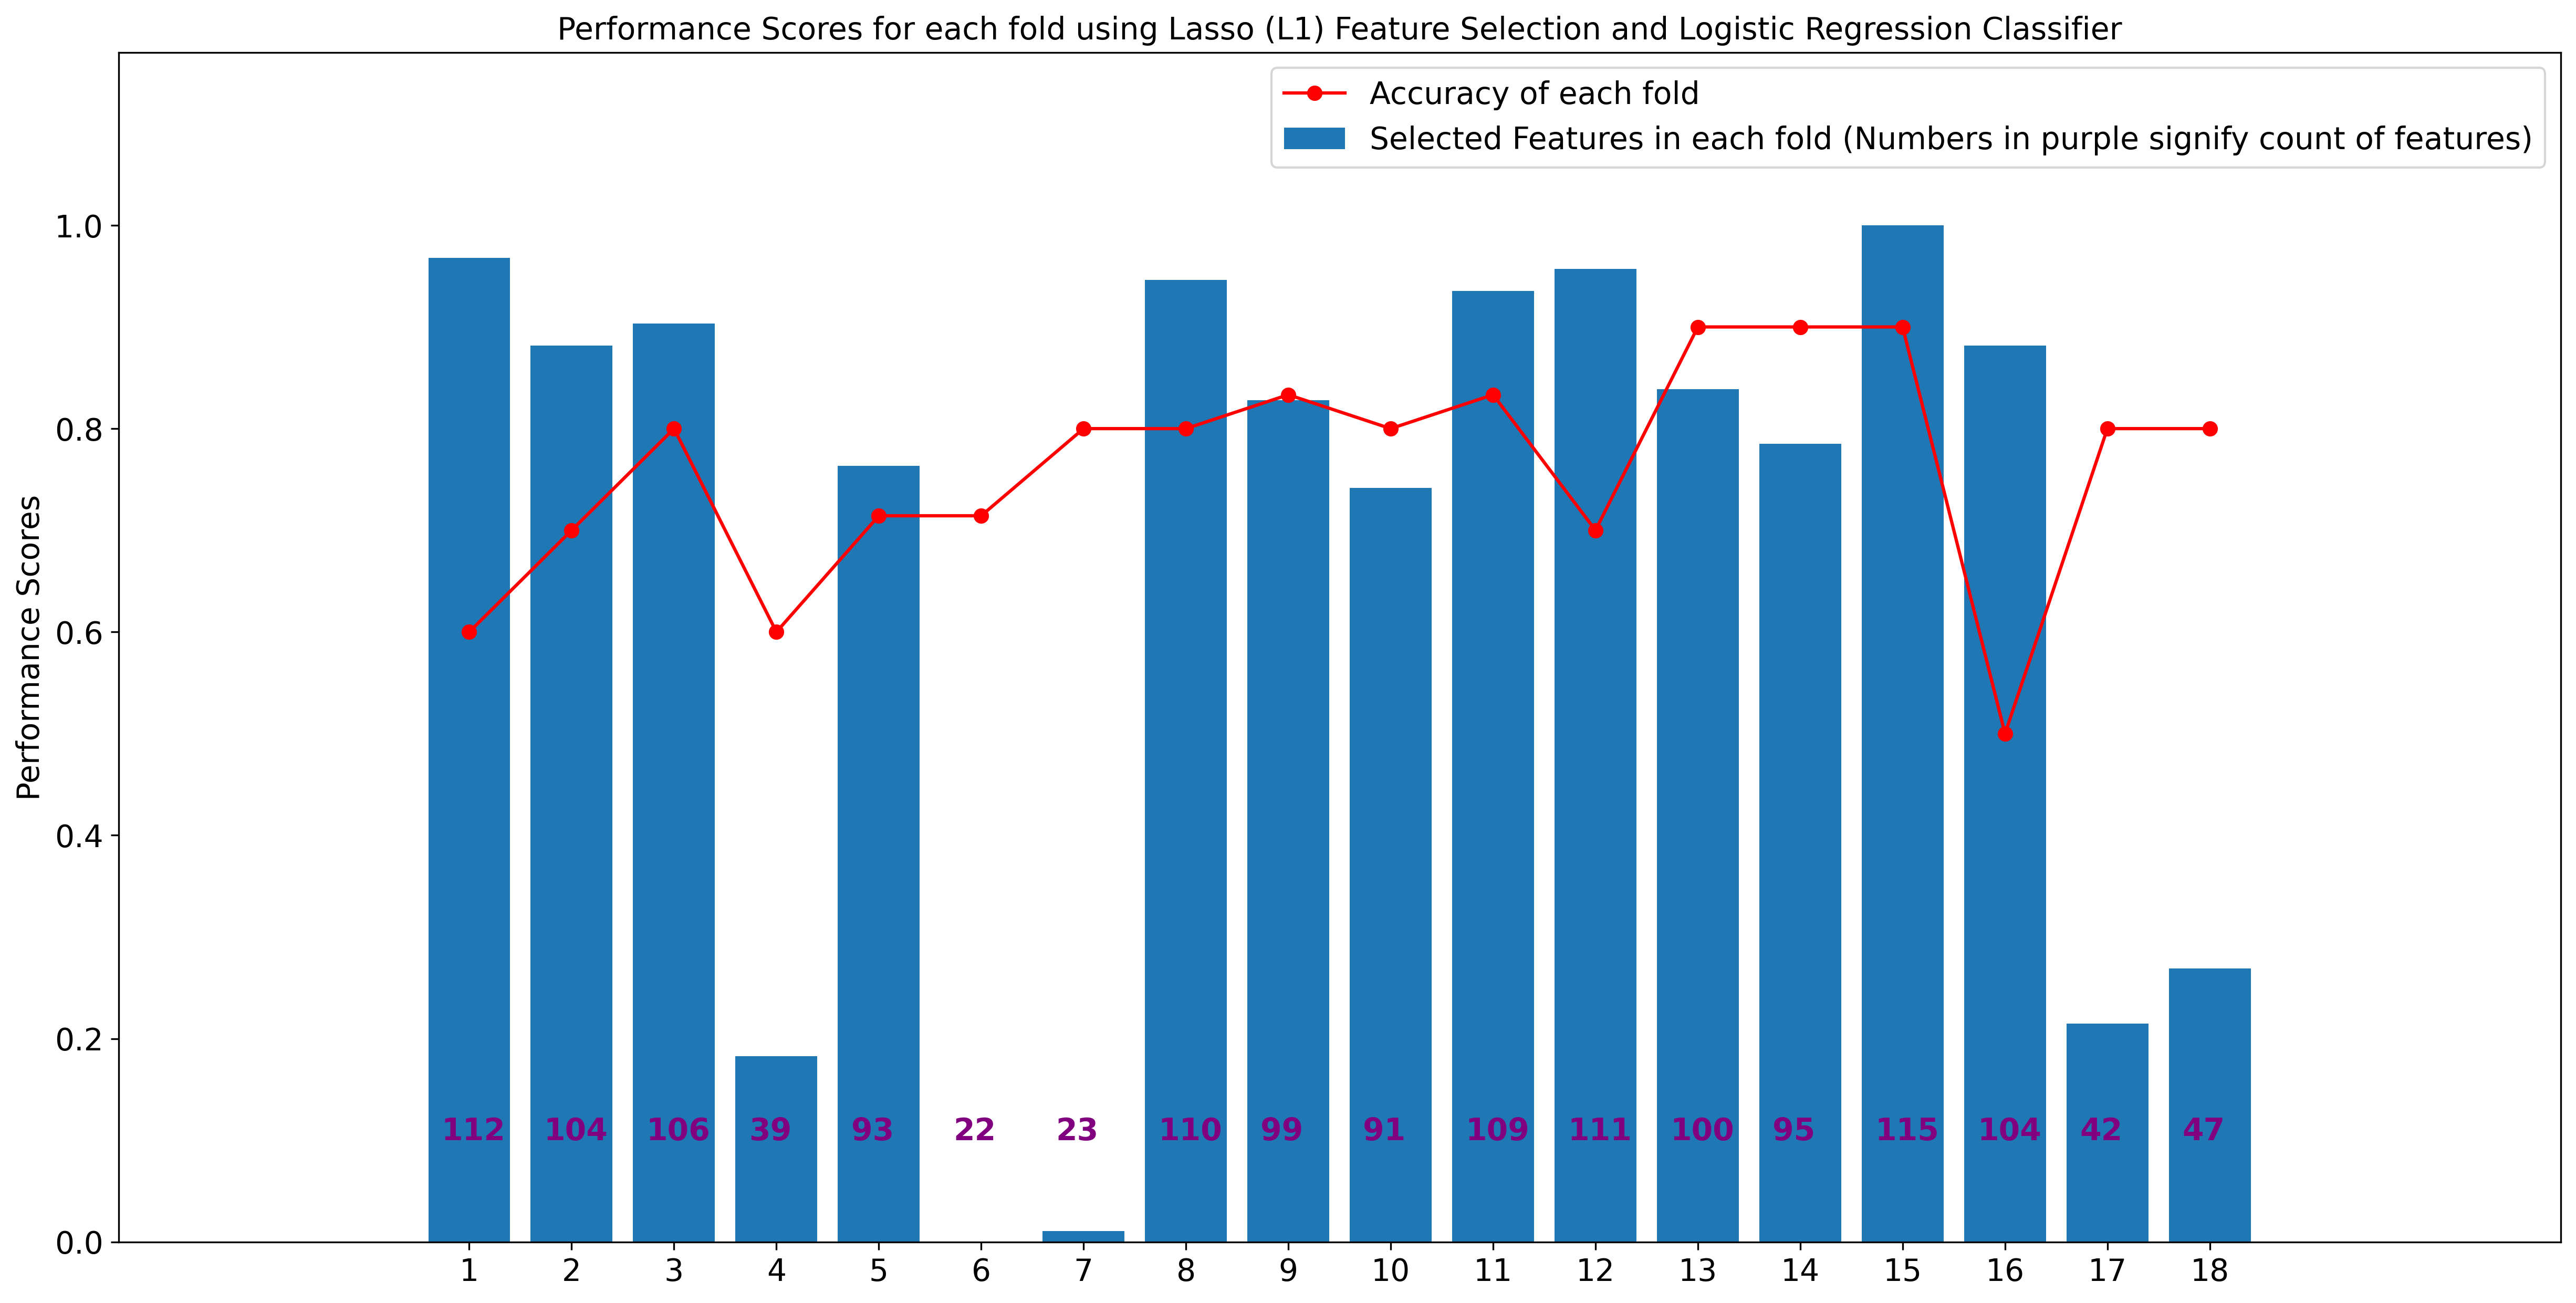

In [18]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using Lasso (L1) Feature Selection and Logistic Regression Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found.
The plot clearly shows that the folds with atleast 105-110 best features selected have accuracy closer to 1.
This tells that for Logistic Regression classifier, the optimal number of features to be selected would be in the same range.

#### a. ii) Calculation of the mean performance meaures using confusion matrix

In [19]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

embed_scores_df.loc['Logistic Regression'].iat[0] = accuracy
embed_scores_df.loc['Logistic Regression'].iat[1] = accuracy_std
embed_scores_df.loc['Logistic Regression'].iat[2] = precision
embed_scores_df.loc['Logistic Regression'].iat[3] = recall
embed_scores_df.loc['Logistic Regression'].iat[4] = specificity
embed_scores_df.loc['Logistic Regression'].iat[5] = sensitivity

#### a. iii) Performance scores across all folds using confusion matrix

In [20]:
embed_scores_df.loc[['Logistic Regression']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.811111,0.107838,0.858491,0.827273,0.785714,0.827273


### b. Using Linear SVM as Classifier

In [21]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Feature Selection
    lasso_feature_selection = LassoCV(
        cv=level2_kf, 
        max_iter=10000, 
        random_state=42, 
        selection='random'
    ).fit(X_train, y_train)
    
    selected_feature_index = np.where(lasso_feature_selection.coef_!=0)[0]
    selected_features_folds.append(selected_feature_index.shape[0])
    
    # Train the model
    model_svm.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
    y_predicted = model_svm.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### b. i) Visualisation of Performance scores for each fold

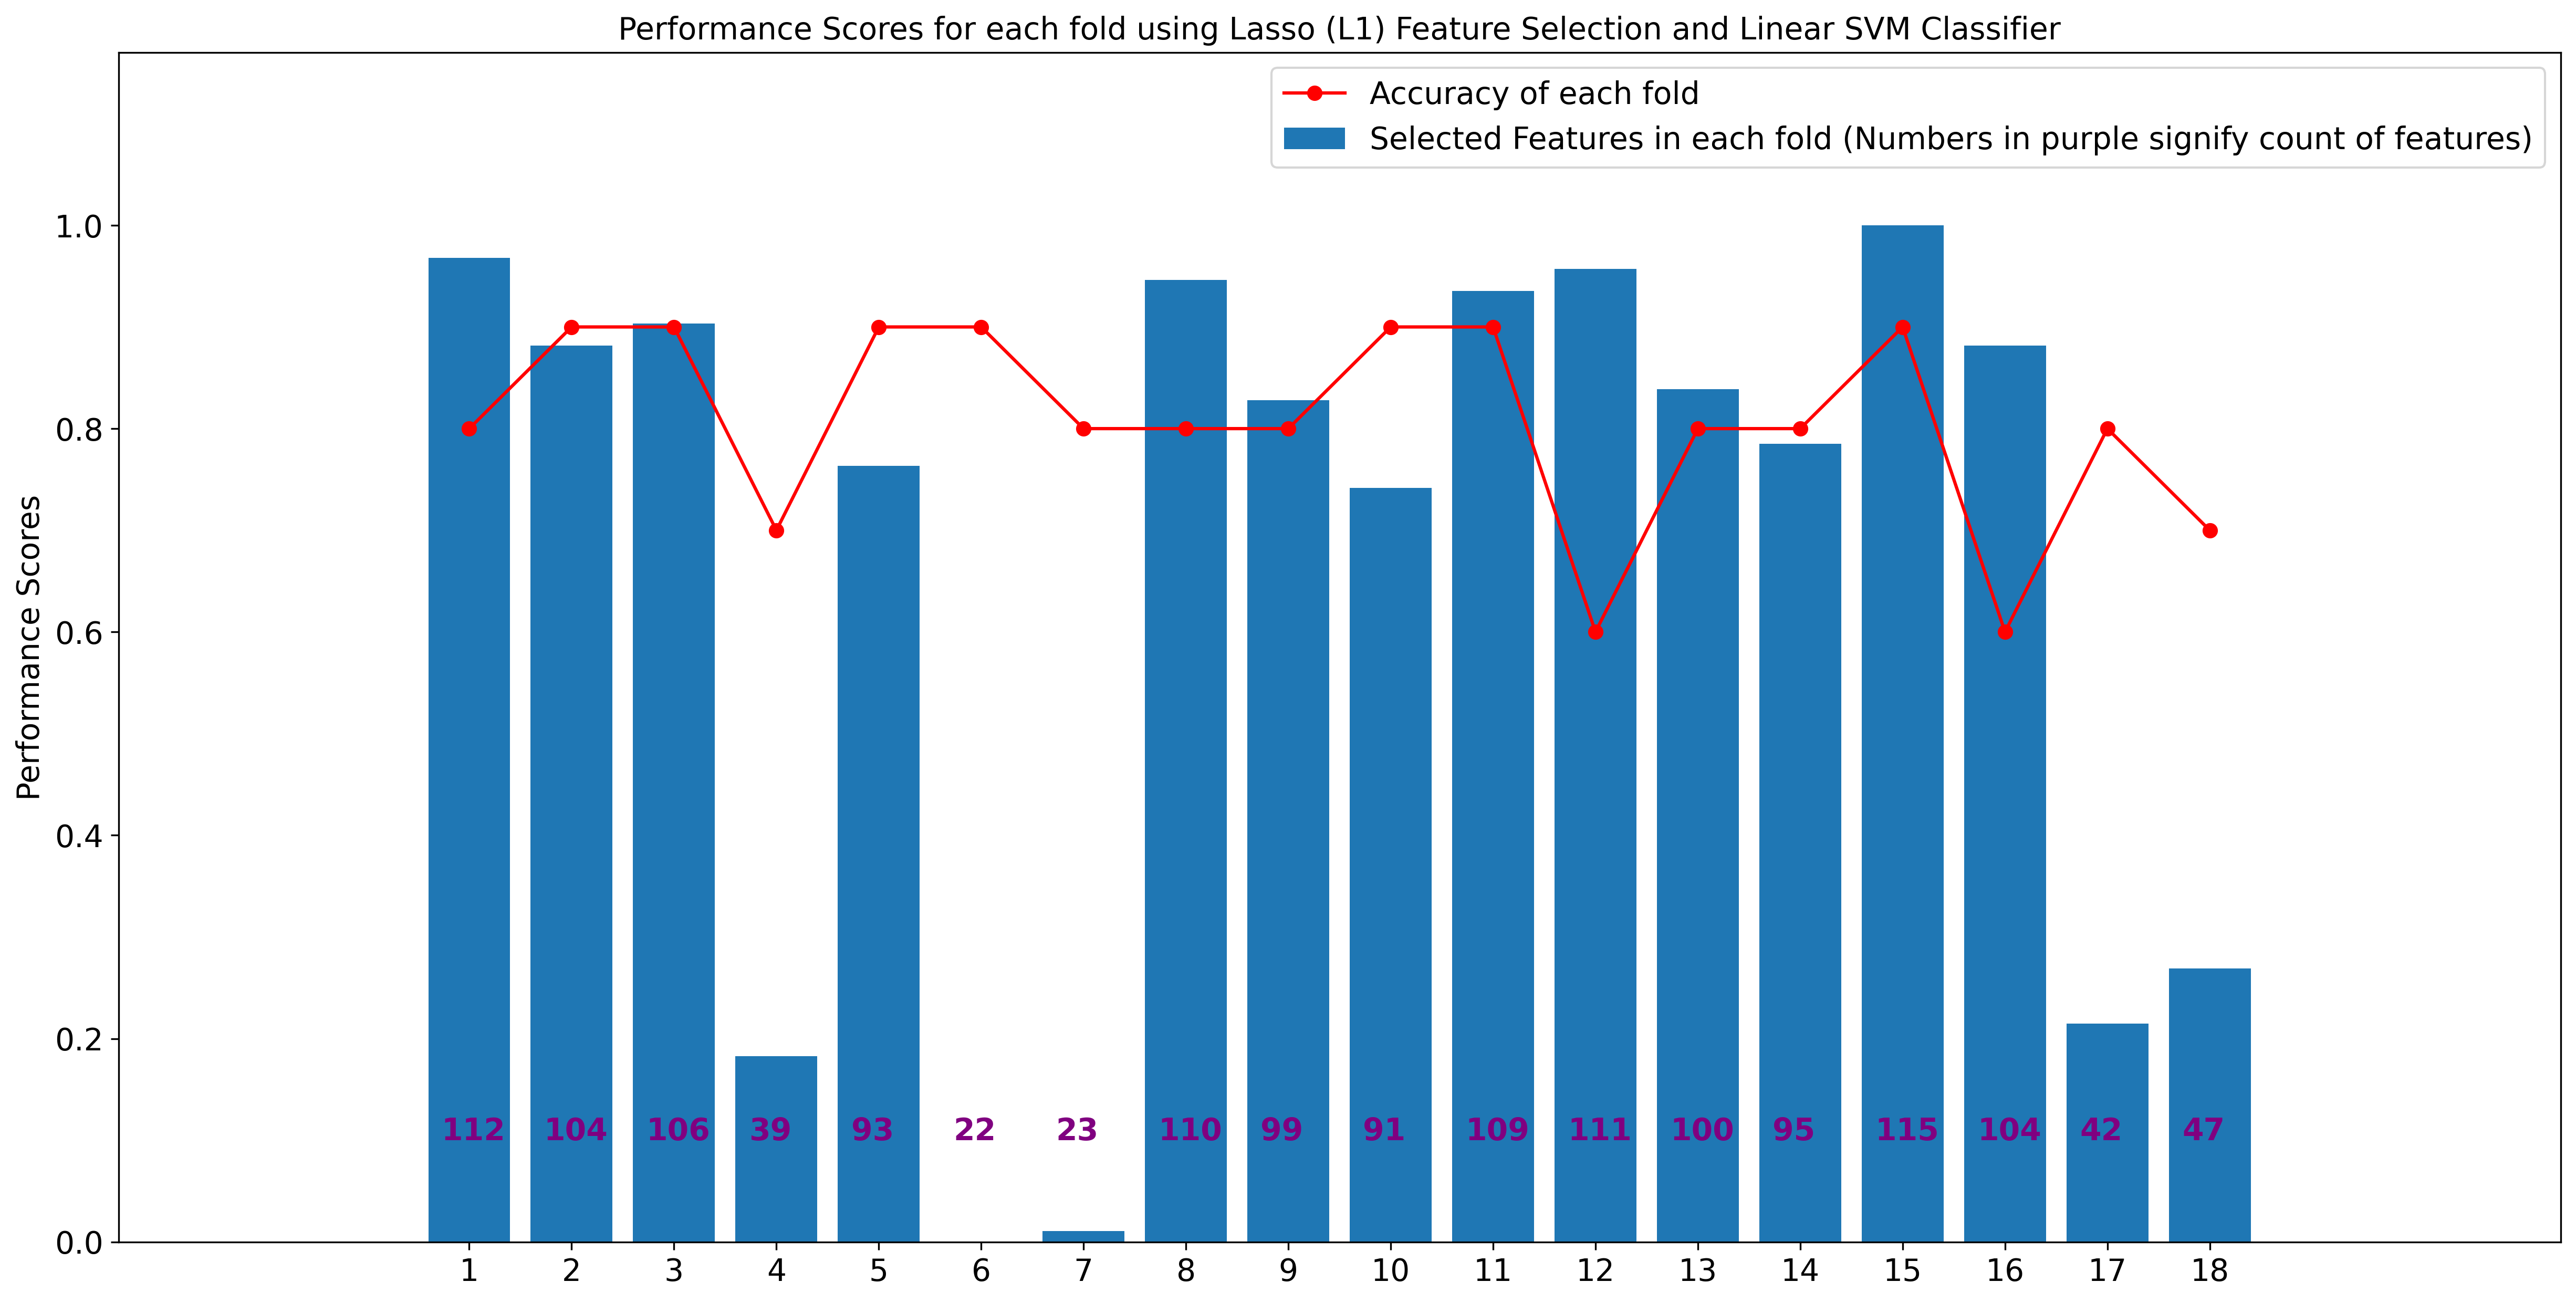

In [22]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using Lasso (L1) Feature Selection and Linear SVM Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found.
While the plot shows sporadic nature such that we can derive a range of optimal number of features, most of the folds with number of best features within 90-110 showed accuracy closer to 1. Thus, this broader range can be considered optimal for the Linear SVM Classifier. 

#### b. ii) Calculation of the mean performance meaures using confusion matrix

In [23]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

embed_scores_df.loc['Linear SVM'].iat[0] = accuracy
embed_scores_df.loc['Linear SVM'].iat[1] = accuracy_std
embed_scores_df.loc['Linear SVM'].iat[2] = precision
embed_scores_df.loc['Linear SVM'].iat[3] = recall
embed_scores_df.loc['Linear SVM'].iat[4] = specificity
embed_scores_df.loc['Linear SVM'].iat[5] = sensitivity

#### b. iii) Performance scores across all folds using confusion matrix

In [24]:
embed_scores_df.loc[['Linear SVM']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Linear SVM,0.805556,0.097024,0.815534,0.84,0.7625,0.84


### Part 2 - Performance Evaluation
### Performance comparison of Classifiers for Embedded Method

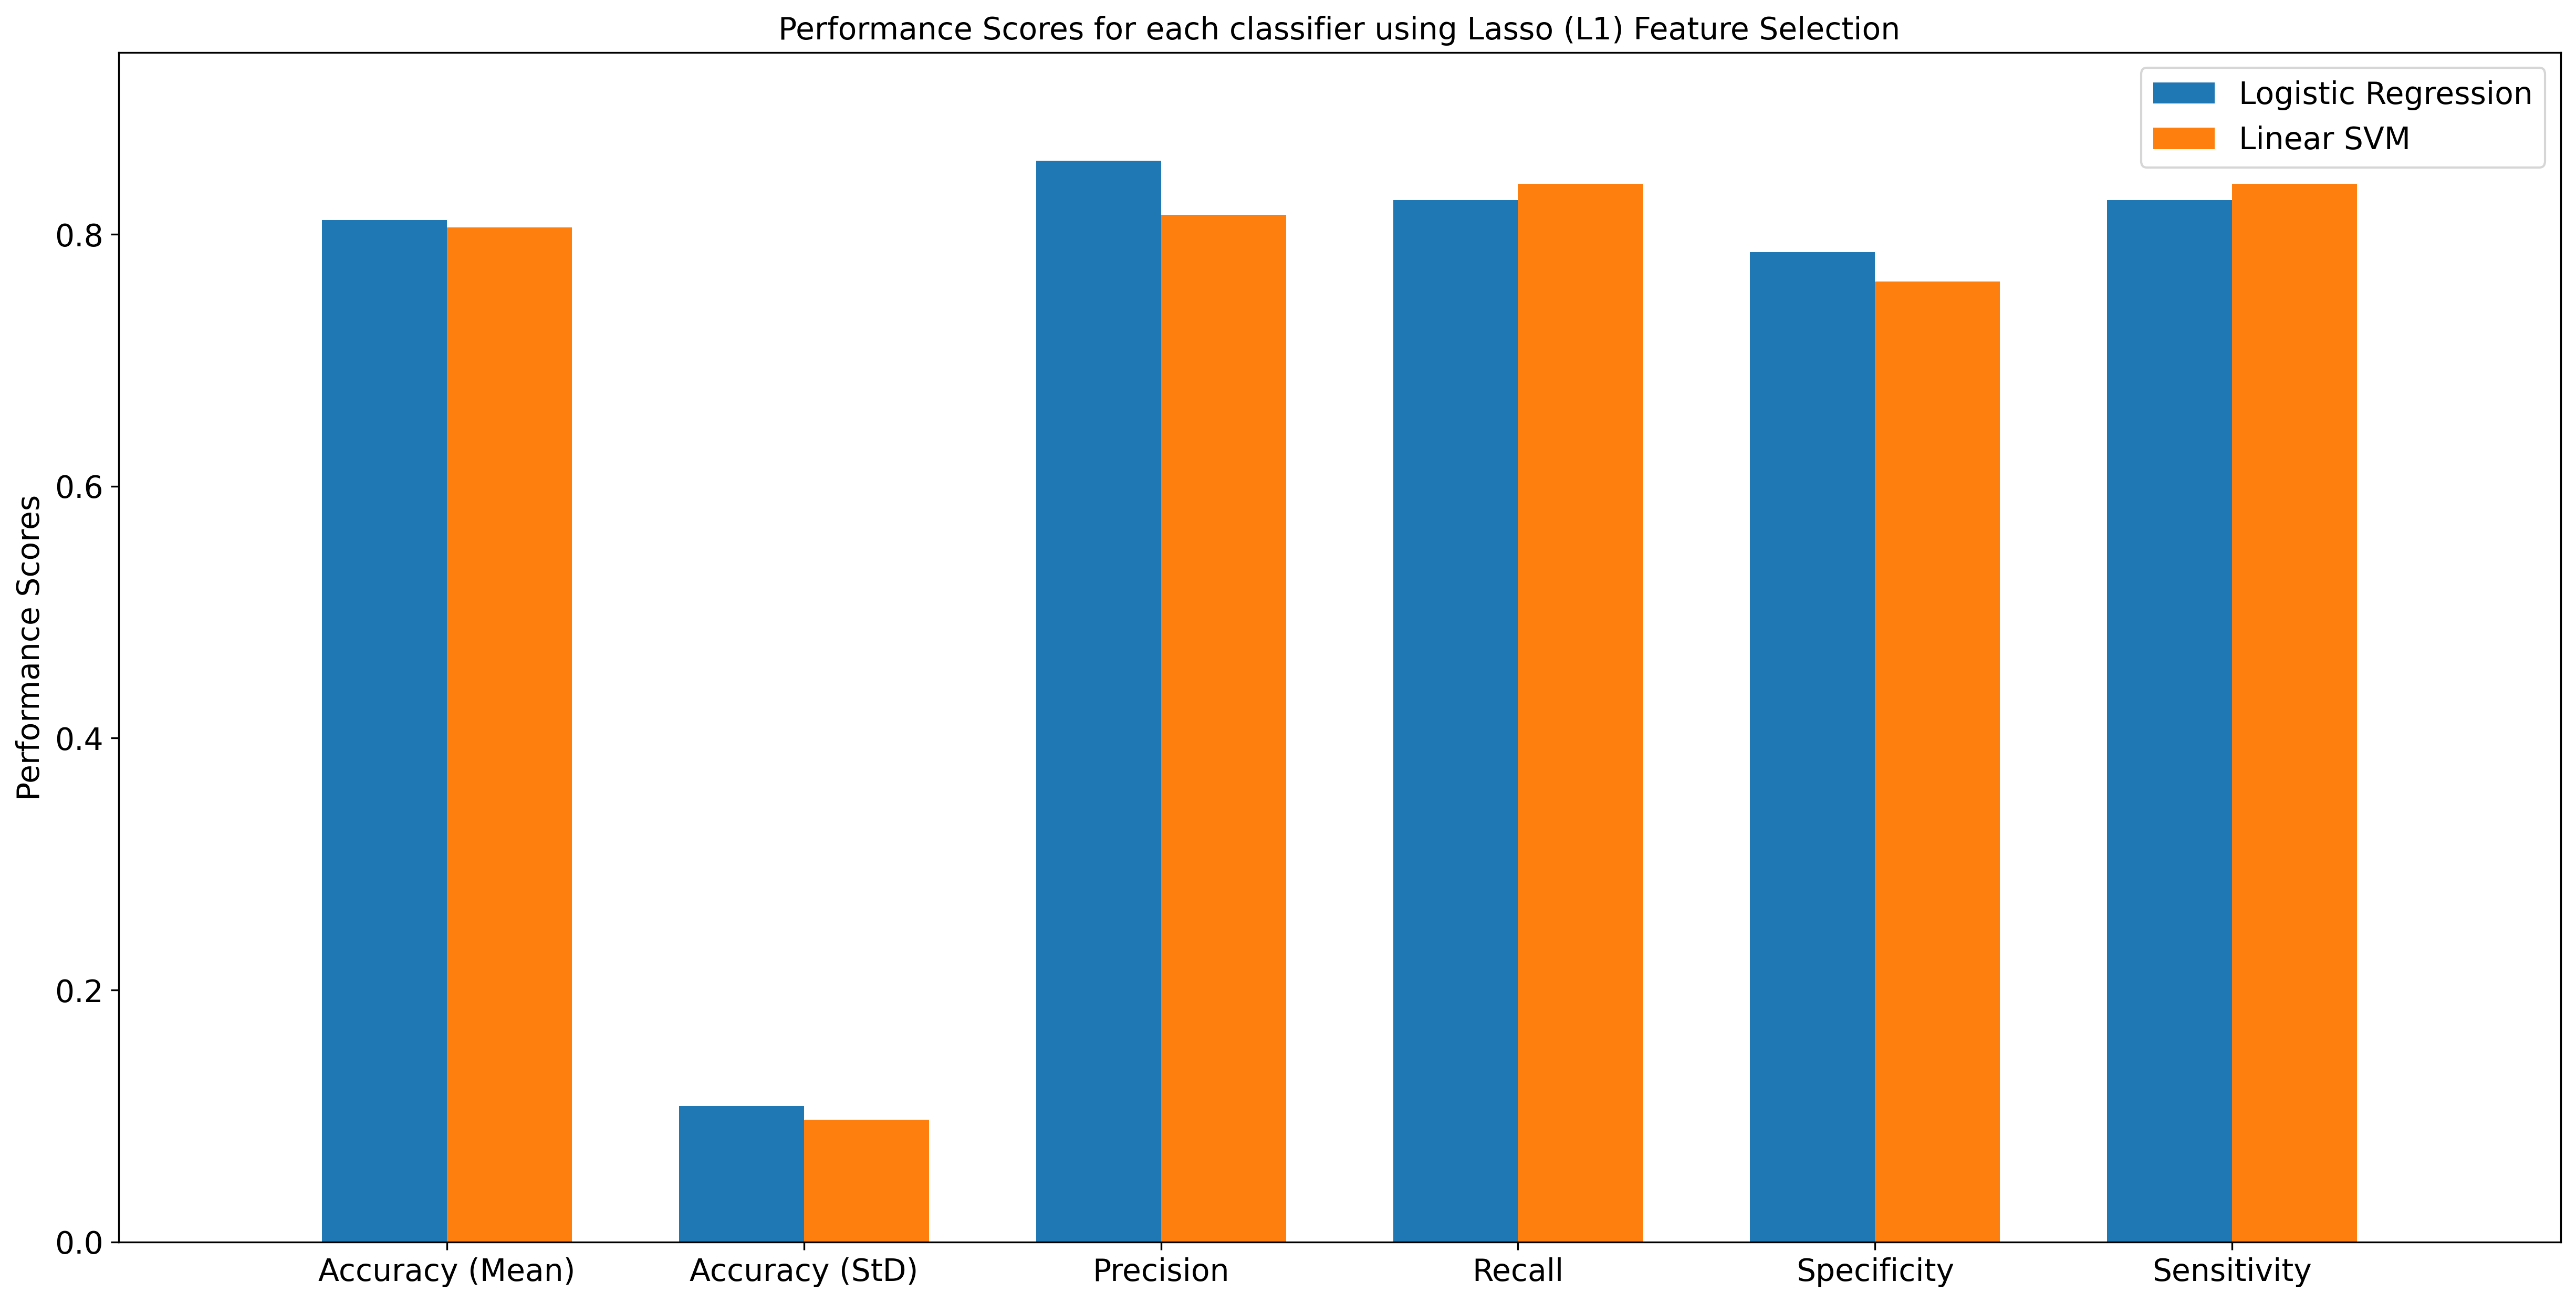

In [25]:
labels = list(embed_scores_df.columns)
lr_scores = embed_scores_df.loc['Logistic Regression'].tolist()
svm_scores = embed_scores_df.loc['Linear SVM'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, svm_scores, width, label='Linear SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each classifier using Lasso (L1) Feature Selection', fontsize=14)
ax.set_xticks(x) # values
ax.set_xticklabels(labels) # labels
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.1)

plt.show()

The above plot marks 5 mean performance scores - accuracy (mean and std), precision, Recall, Specificity and Sensitivity (same as Recall) across each fold run between the 2 classifiers used for Embedded Method. Based on the results displayed, it is easy to infer that both classifiers performed similarly (in terms of accuracy), but with less accuracy than when the classifiers are run without any feature selection across folds.

#  

## 2. Wrapper Method (Recursive Feature Elimination)

### Part 1 - Model training and testing
### a. Using Logistic Regression as Classifier

In [26]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Feature Selection
    rfe_feature_selection = RFECV(
        estimator=model_lr,
        cv=level2_kf,
        scoring="accuracy",
    ).fit(X_train, y_train)

    selected_feature_index = np.where(rfe_feature_selection.ranking_==1)[0]
    selected_features_folds.append(selected_feature_index.shape[0])

    # Train the model
    model_lr.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
    y_predicted = model_lr.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### a. i) Visualisation of Performance scores for each fold

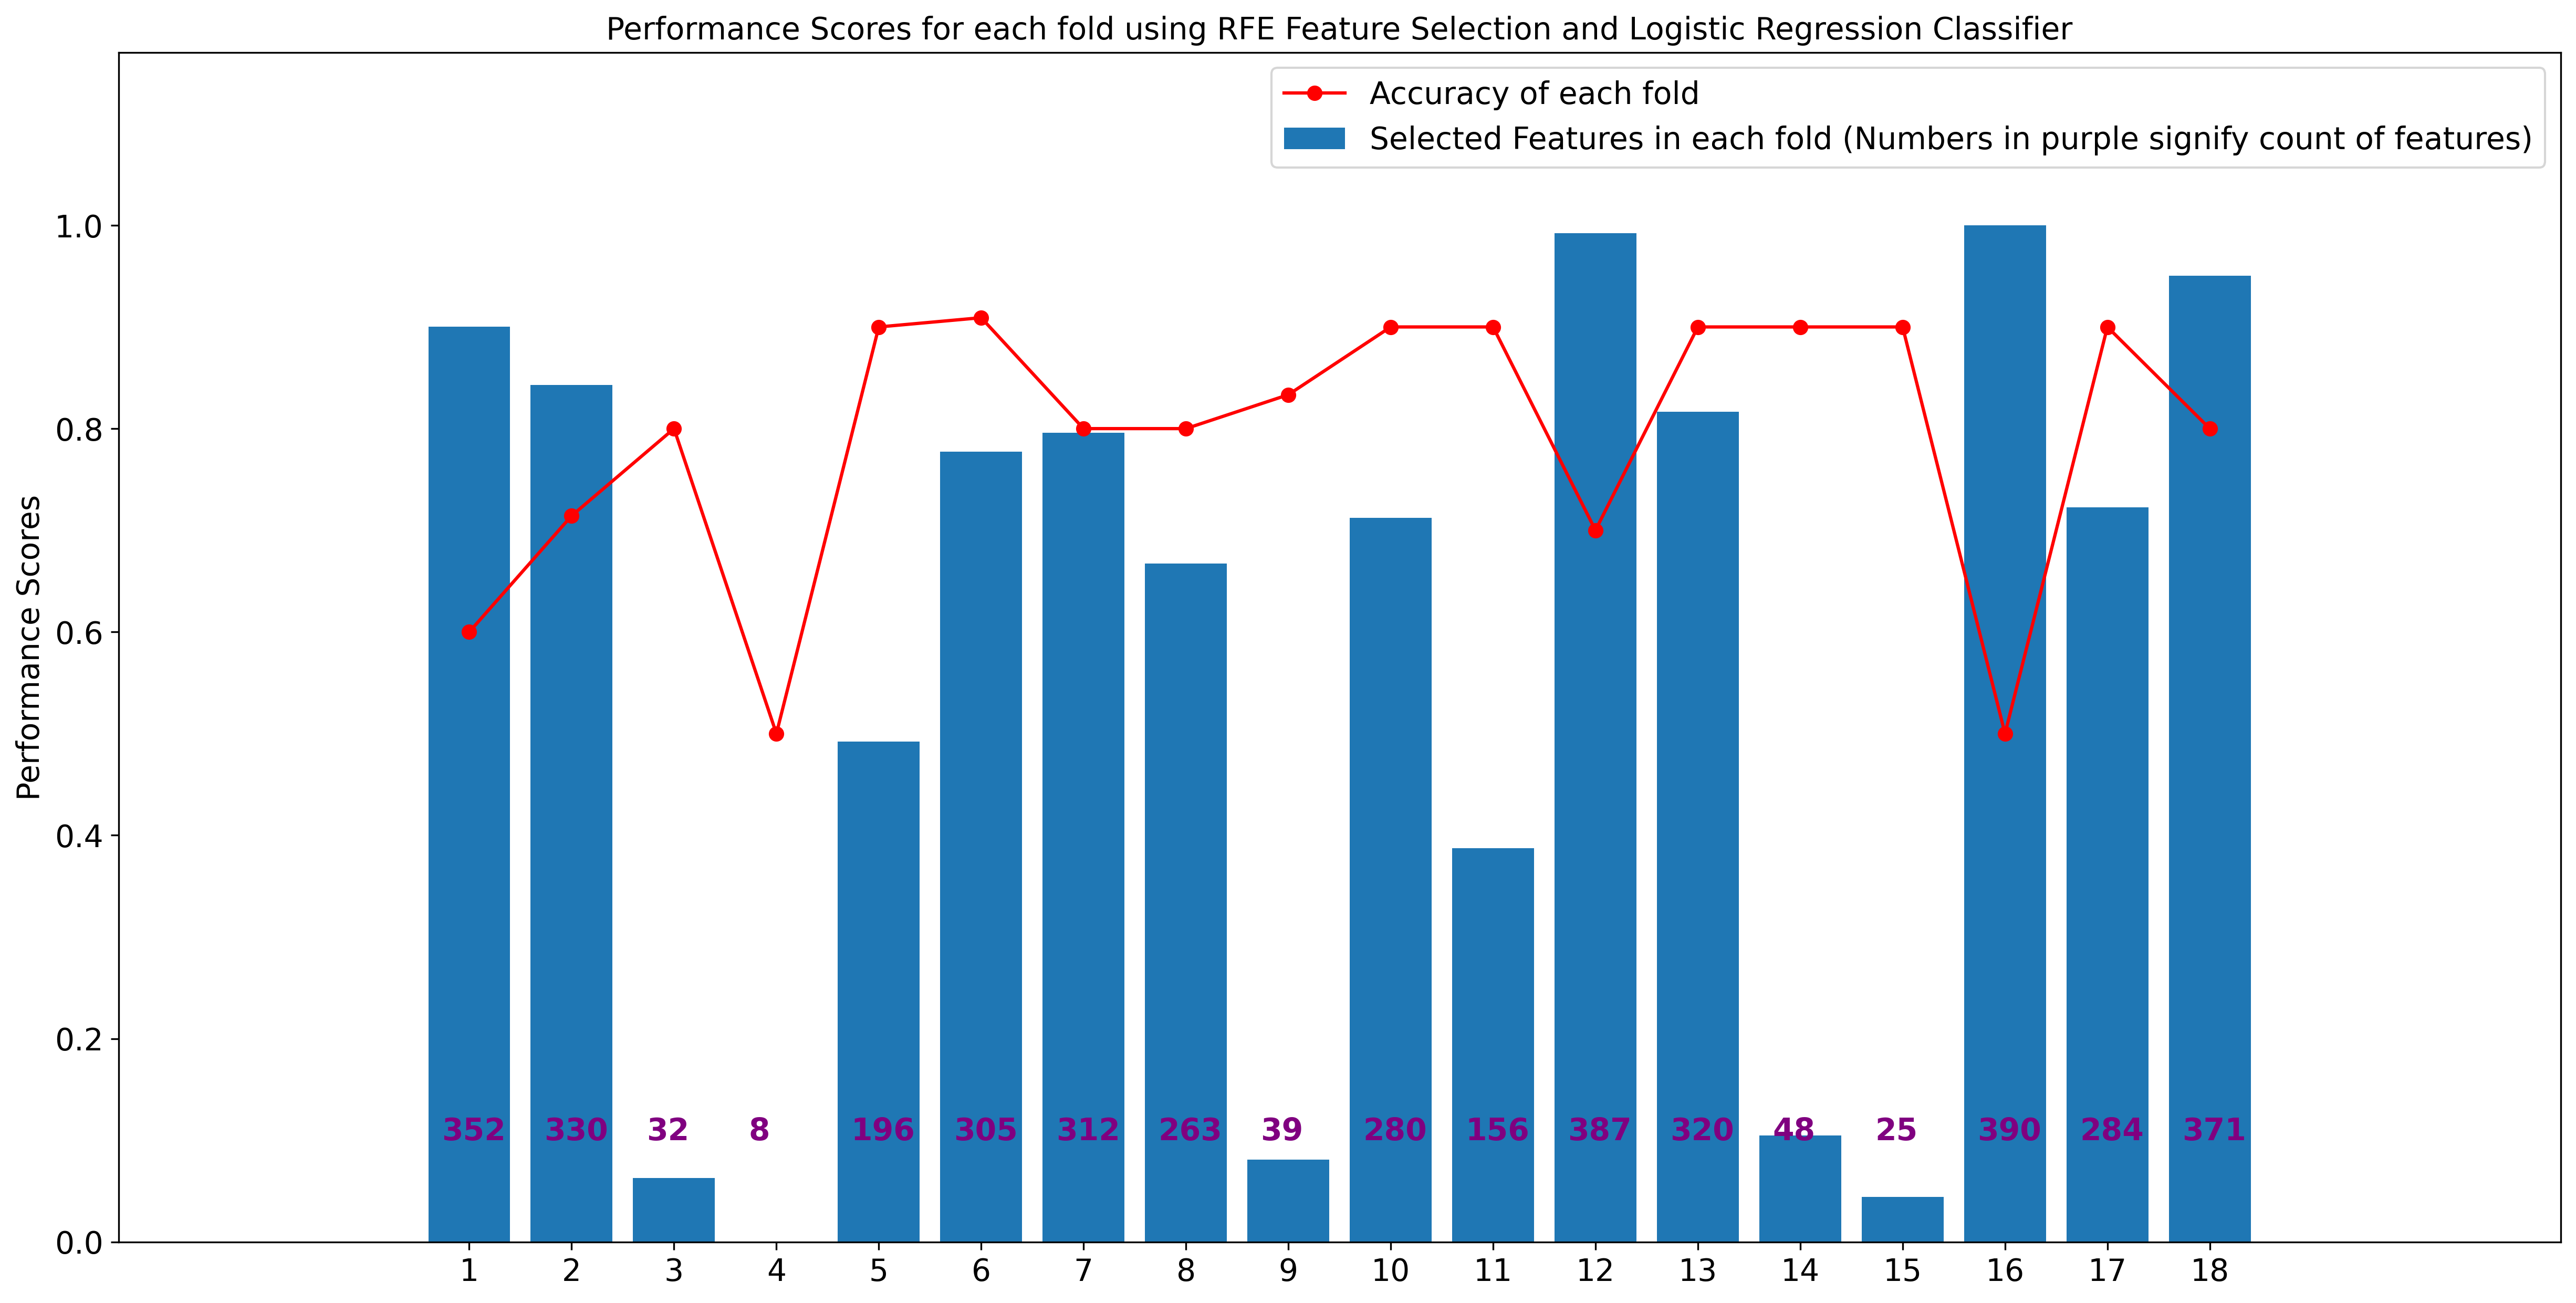

In [27]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using RFE Feature Selection and Logistic Regression Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found. While the plot shows sporadic nature such that we can derive a range of optimal number of features, most of the folds with number of best features within 150-310 showed accuracy closest to 1. Thus, this broader range can be considered optimal for the Logistic Regression Classifier using RFE Feature Selection.

#### a. ii) Calculation of the mean performance meaures using confusion matrix

In [28]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

wrapper_scores_df.loc['Logistic Regression'].iat[0] = accuracy
wrapper_scores_df.loc['Logistic Regression'].iat[1] = accuracy_std
wrapper_scores_df.loc['Logistic Regression'].iat[2] = precision
wrapper_scores_df.loc['Logistic Regression'].iat[3] = recall
wrapper_scores_df.loc['Logistic Regression'].iat[4] = specificity
wrapper_scores_df.loc['Logistic Regression'].iat[5] = sensitivity

#### a. iii) Performance scores across all folds using confusion matrix

In [29]:
wrapper_scores_df.loc[['Logistic Regression']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.822222,0.13317,0.846939,0.83,0.8125,0.83


### b. Using Linear SVM as Classifier

In [30]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Feature Selection
    rfe_feature_selection = RFECV(
        estimator=model_svm,
        cv=level2_kf,
        scoring="accuracy",
    ).fit(X_train, y_train)
    
    selected_feature_index = np.where(rfe_feature_selection.ranking_==1)[0]
    selected_features_folds.append(selected_feature_index.shape[0])

    # Train the model
    model_svm.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
    y_predicted = model_svm.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### b. i) Visualisation of Performance scores for each fold

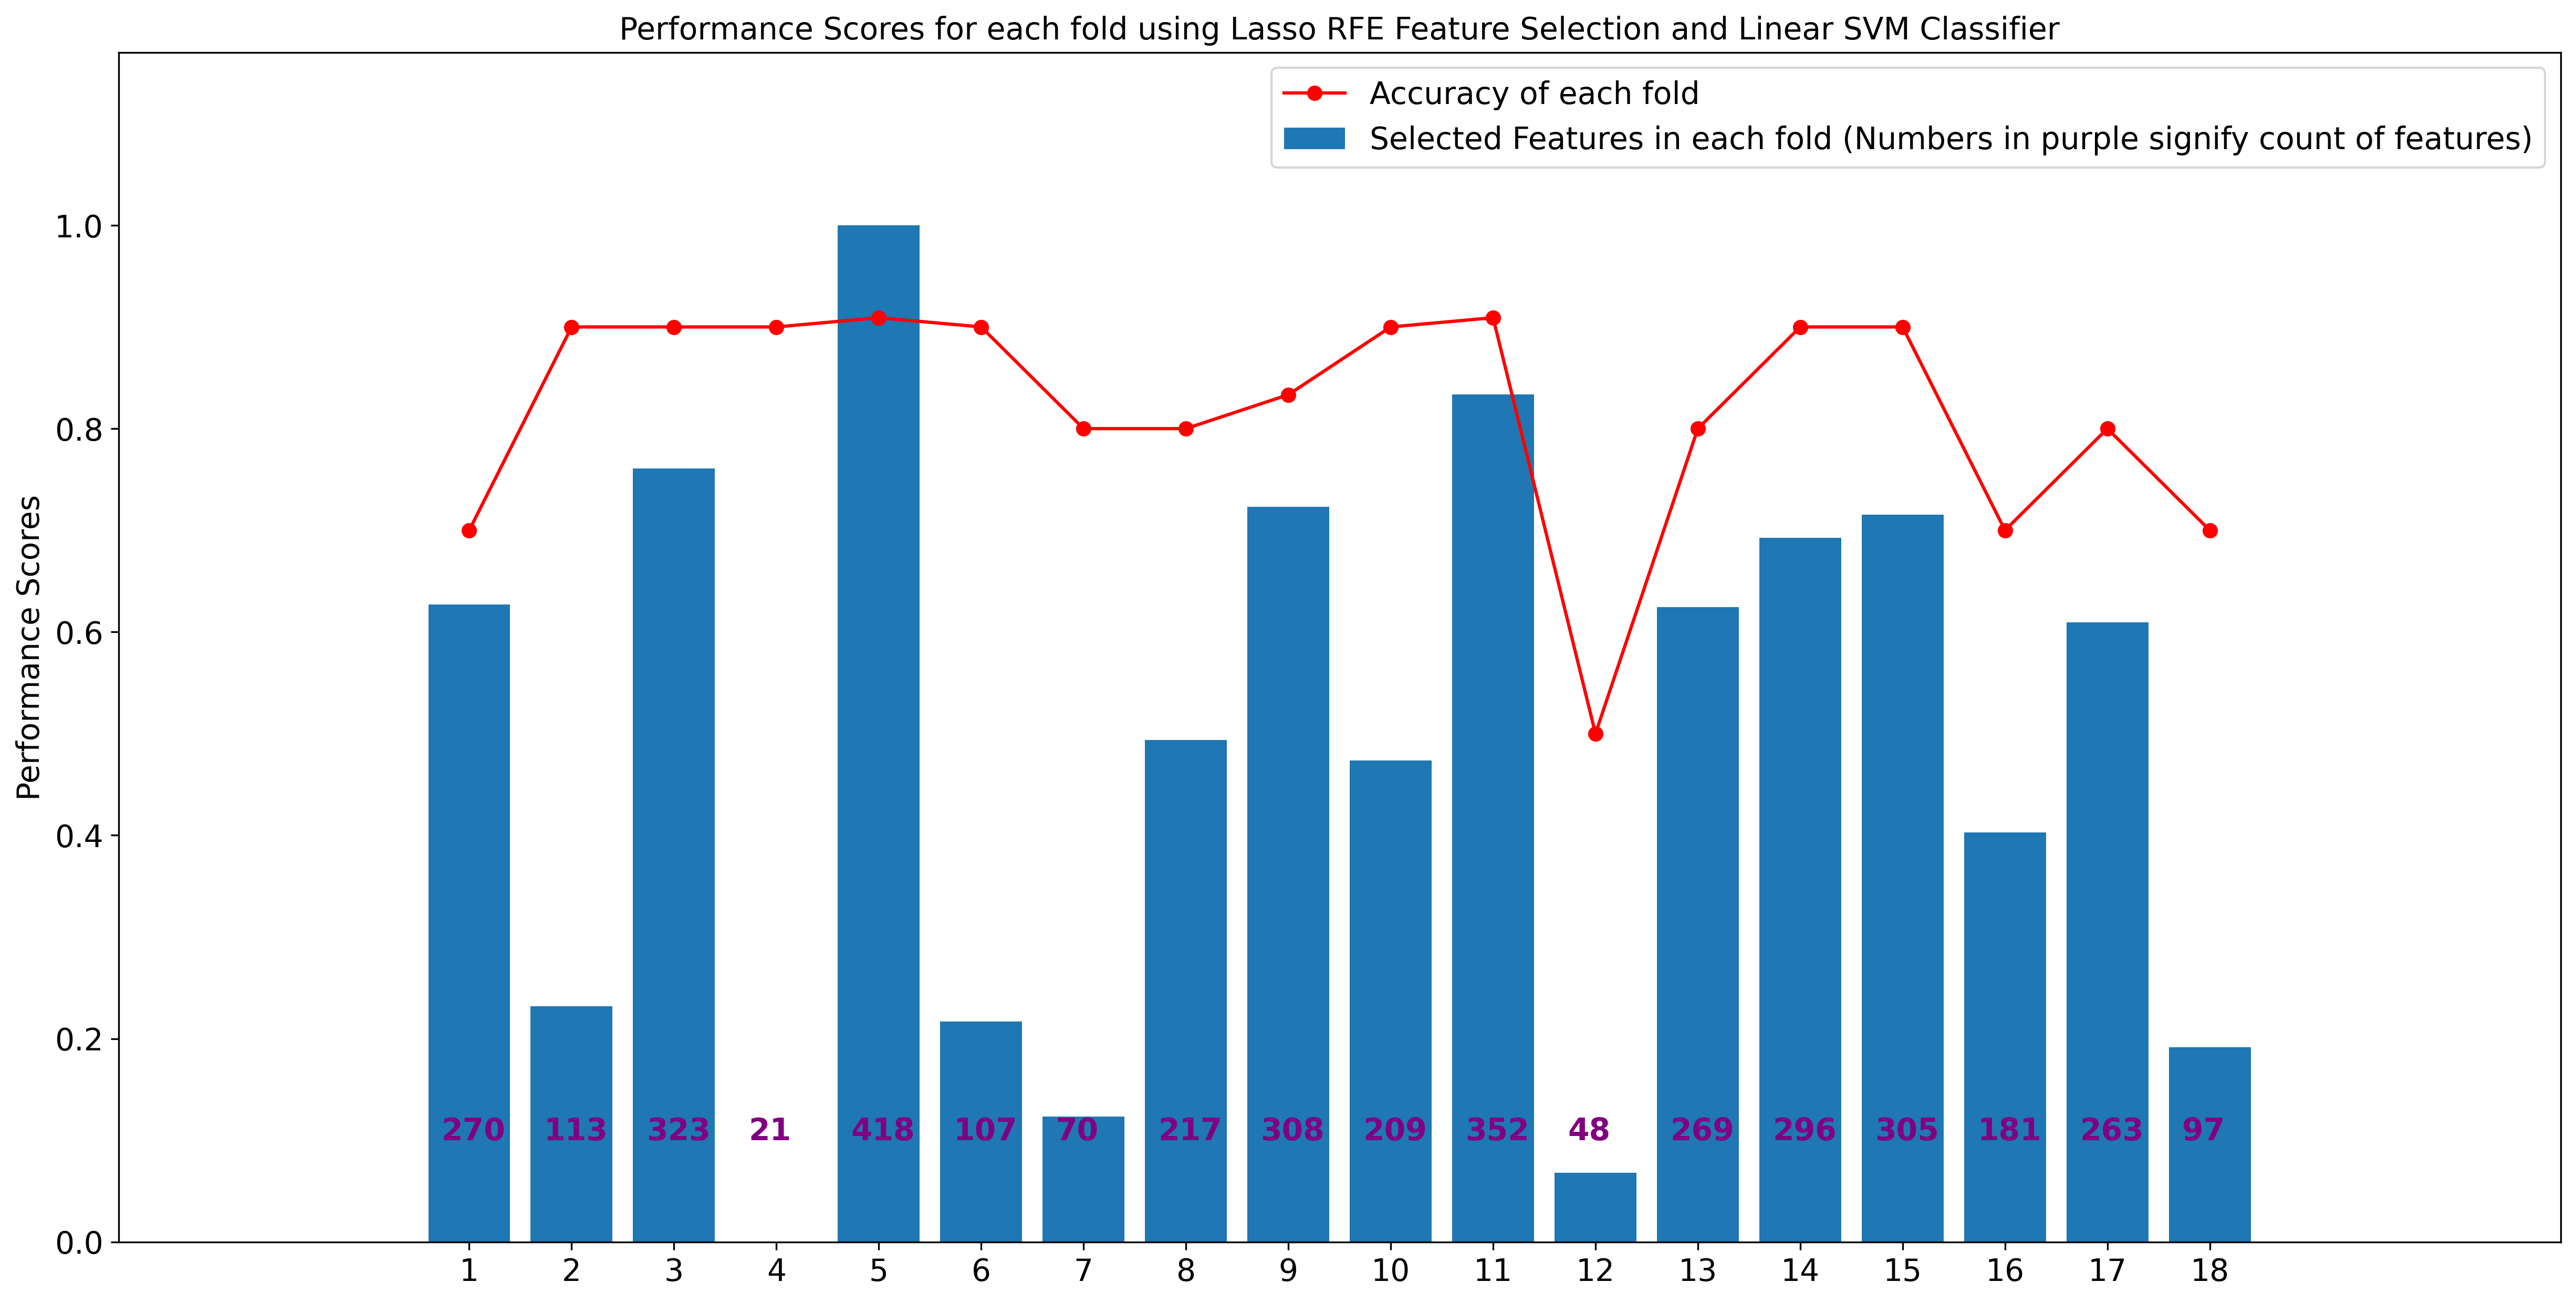

In [31]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using Lasso RFE Feature Selection and Linear SVM Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found. While the plot shows sporadic nature such that we can derive a range of optimal number of features, most of the folds with number of best features within 110-210 and 290-420 showed accuracy closest to 1. Thus, this broader range can be considered optimal for the Linear SVM Classifier using RFE Feature Selection.

#### b. ii) Calculation of the mean performance meaures using confusion matrix

In [32]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

wrapper_scores_df.loc['Linear SVM'].iat[0] = accuracy
wrapper_scores_df.loc['Linear SVM'].iat[1] = accuracy_std
wrapper_scores_df.loc['Linear SVM'].iat[2] = precision
wrapper_scores_df.loc['Linear SVM'].iat[3] = recall
wrapper_scores_df.loc['Linear SVM'].iat[4] = specificity
wrapper_scores_df.loc['Linear SVM'].iat[5] = sensitivity

#### b. iii) Performance scores across all folds using confusion matrix

In [33]:
wrapper_scores_df.loc[['Linear SVM']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Linear SVM,0.844444,0.107509,0.870968,0.9,0.733333,0.9


### Part 2 - Performance Evaluation
### Performance comparison of Classifiers for Wrapper Method

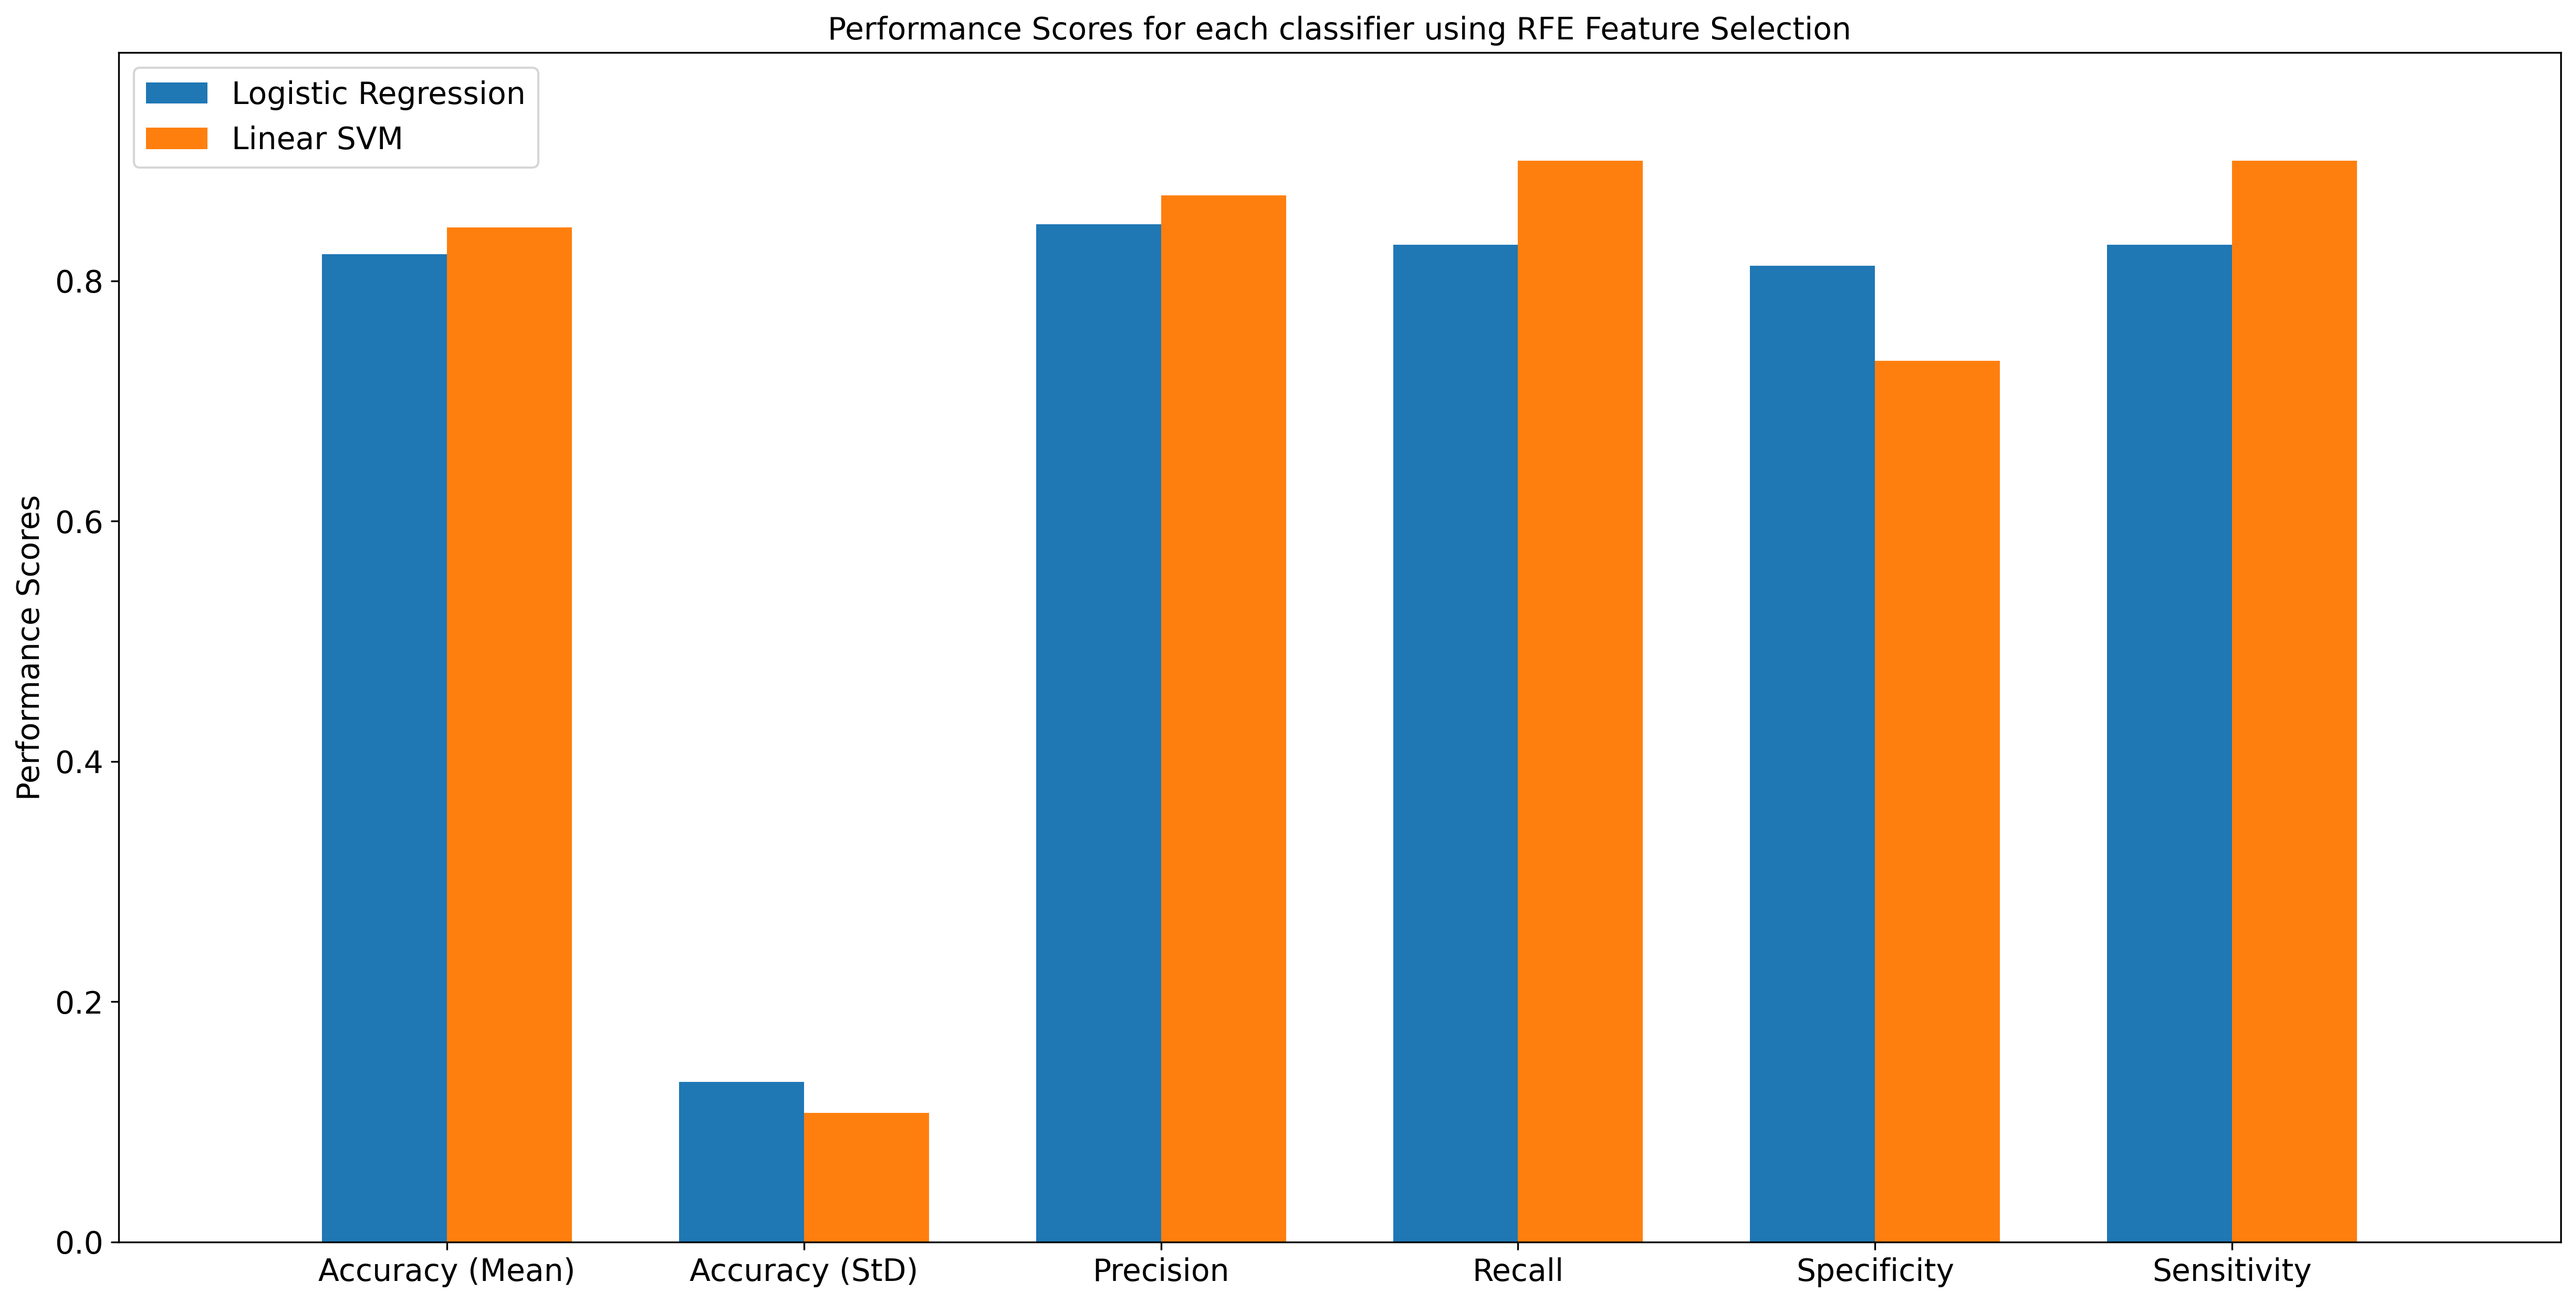

In [34]:
labels = list(wrapper_scores_df.columns)
lr_scores = wrapper_scores_df.loc['Logistic Regression'].tolist()
svm_scores = wrapper_scores_df.loc['Linear SVM'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, svm_scores, width, label='Linear SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each classifier using RFE Feature Selection', fontsize=14)
ax.set_xticks(x) # values
ax.set_xticklabels(labels) # labels
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.1)

plt.show()

The above plot marks 5 mean performance scores - accuracy (mean and std), precision, Recall, Specificity and Sensitivity (same as Recall) across each fold run between the 2 classifiers used for Wrapper Method. Based on the results displayed, it is easy to infer that both classifiers performed similarly (in terms of accuracy), but with less accuracy than when the classifiers are run without any feature selection across folds. 

#  

## 3. Filtering Method (Feature ranking by relevance)

### Part 1 - Model training and testing
### a. Using Logistic Regression as Classifier

In [35]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Feature Selection
    feature_selection = SelectKBest().fit(X_train, y_train) 
    
    selected_feature_index = np.where(feature_selection.scores_>10.0)[0]
    selected_features_folds.append(selected_feature_index.shape[0])
    
    # Train the model
    model_lr.fit(X_train[:, selected_feature_index], y_train)

    # Test the model
    y_predicted = model_lr.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### a. i) Visualisation of Performance scores for each fold

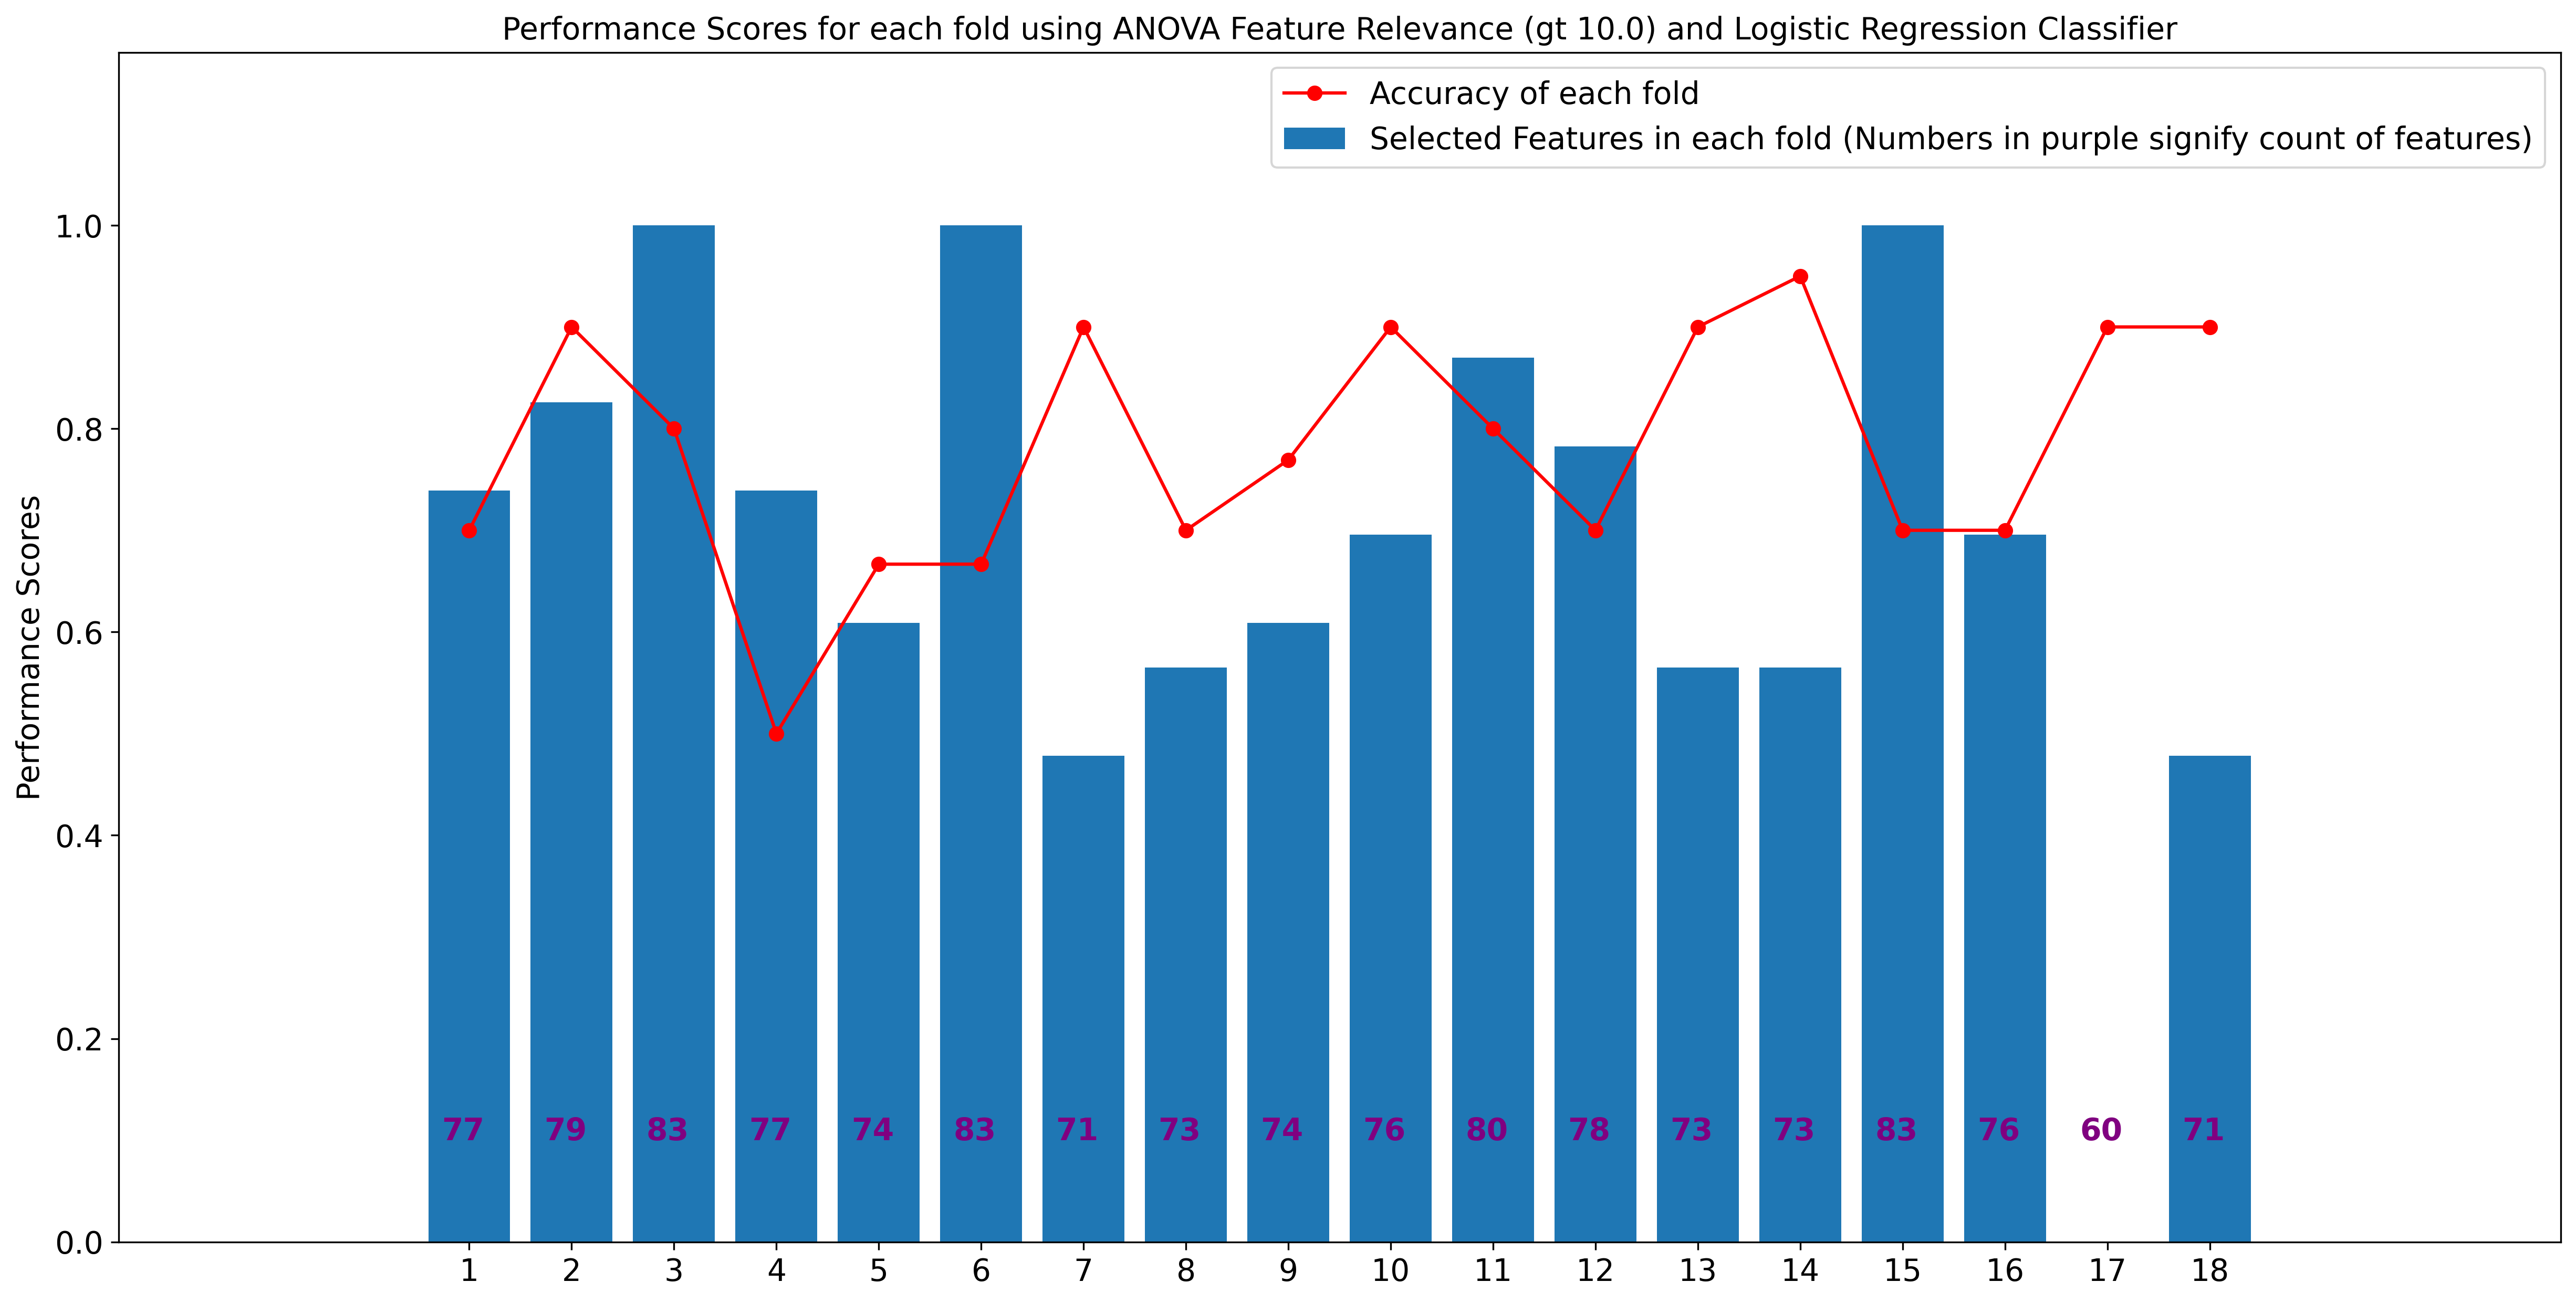

In [36]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using ANOVA Feature Relevance (gt 10.0) and Logistic Regression Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found. While the plot shows sporadic nature such that we can derive a range of optimal number of features, most of the folds with number of best features within 71-83 showed accuracy closest to 1. Thus, this broader range can be considered optimal for the Logistic Regression Classifiern.

#### a. ii) Calculation of the mean performance meaures using confusion matrix

In [37]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

filter_scores_df.loc['Logistic Regression'].iat[0] = accuracy
filter_scores_df.loc['Logistic Regression'].iat[1] = accuracy_std
filter_scores_df.loc['Logistic Regression'].iat[2] = precision
filter_scores_df.loc['Logistic Regression'].iat[3] = recall
filter_scores_df.loc['Logistic Regression'].iat[4] = specificity
filter_scores_df.loc['Logistic Regression'].iat[5] = sensitivity

#### a. iii) Performance scores across all folds using confusion matrix

In [38]:
filter_scores_df.loc[['Logistic Regression']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.833333,0.118391,0.87037,0.854545,0.8,0.854545


### b. Using Linear SVM as Classifier

In [39]:
# Performance measure information
cm_folds, selected_features_folds = list(), list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Feature Selection
    feature_selection = SelectKBest().fit(X_train, y_train) 
    
    selected_feature_index = np.where(feature_selection.scores_>10.0)[0]
    selected_features_folds.append(selected_feature_index.shape[0])
    
    # Train the model
    model_svm.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
    y_predicted = model_svm.predict(X_test[:, selected_feature_index])
    
    # save performance 
    cm = confusion_matrix(y_test, y_predicted)
    cm_folds.append(cm)

#### b. i) Visualisation of Performance scores for each fold

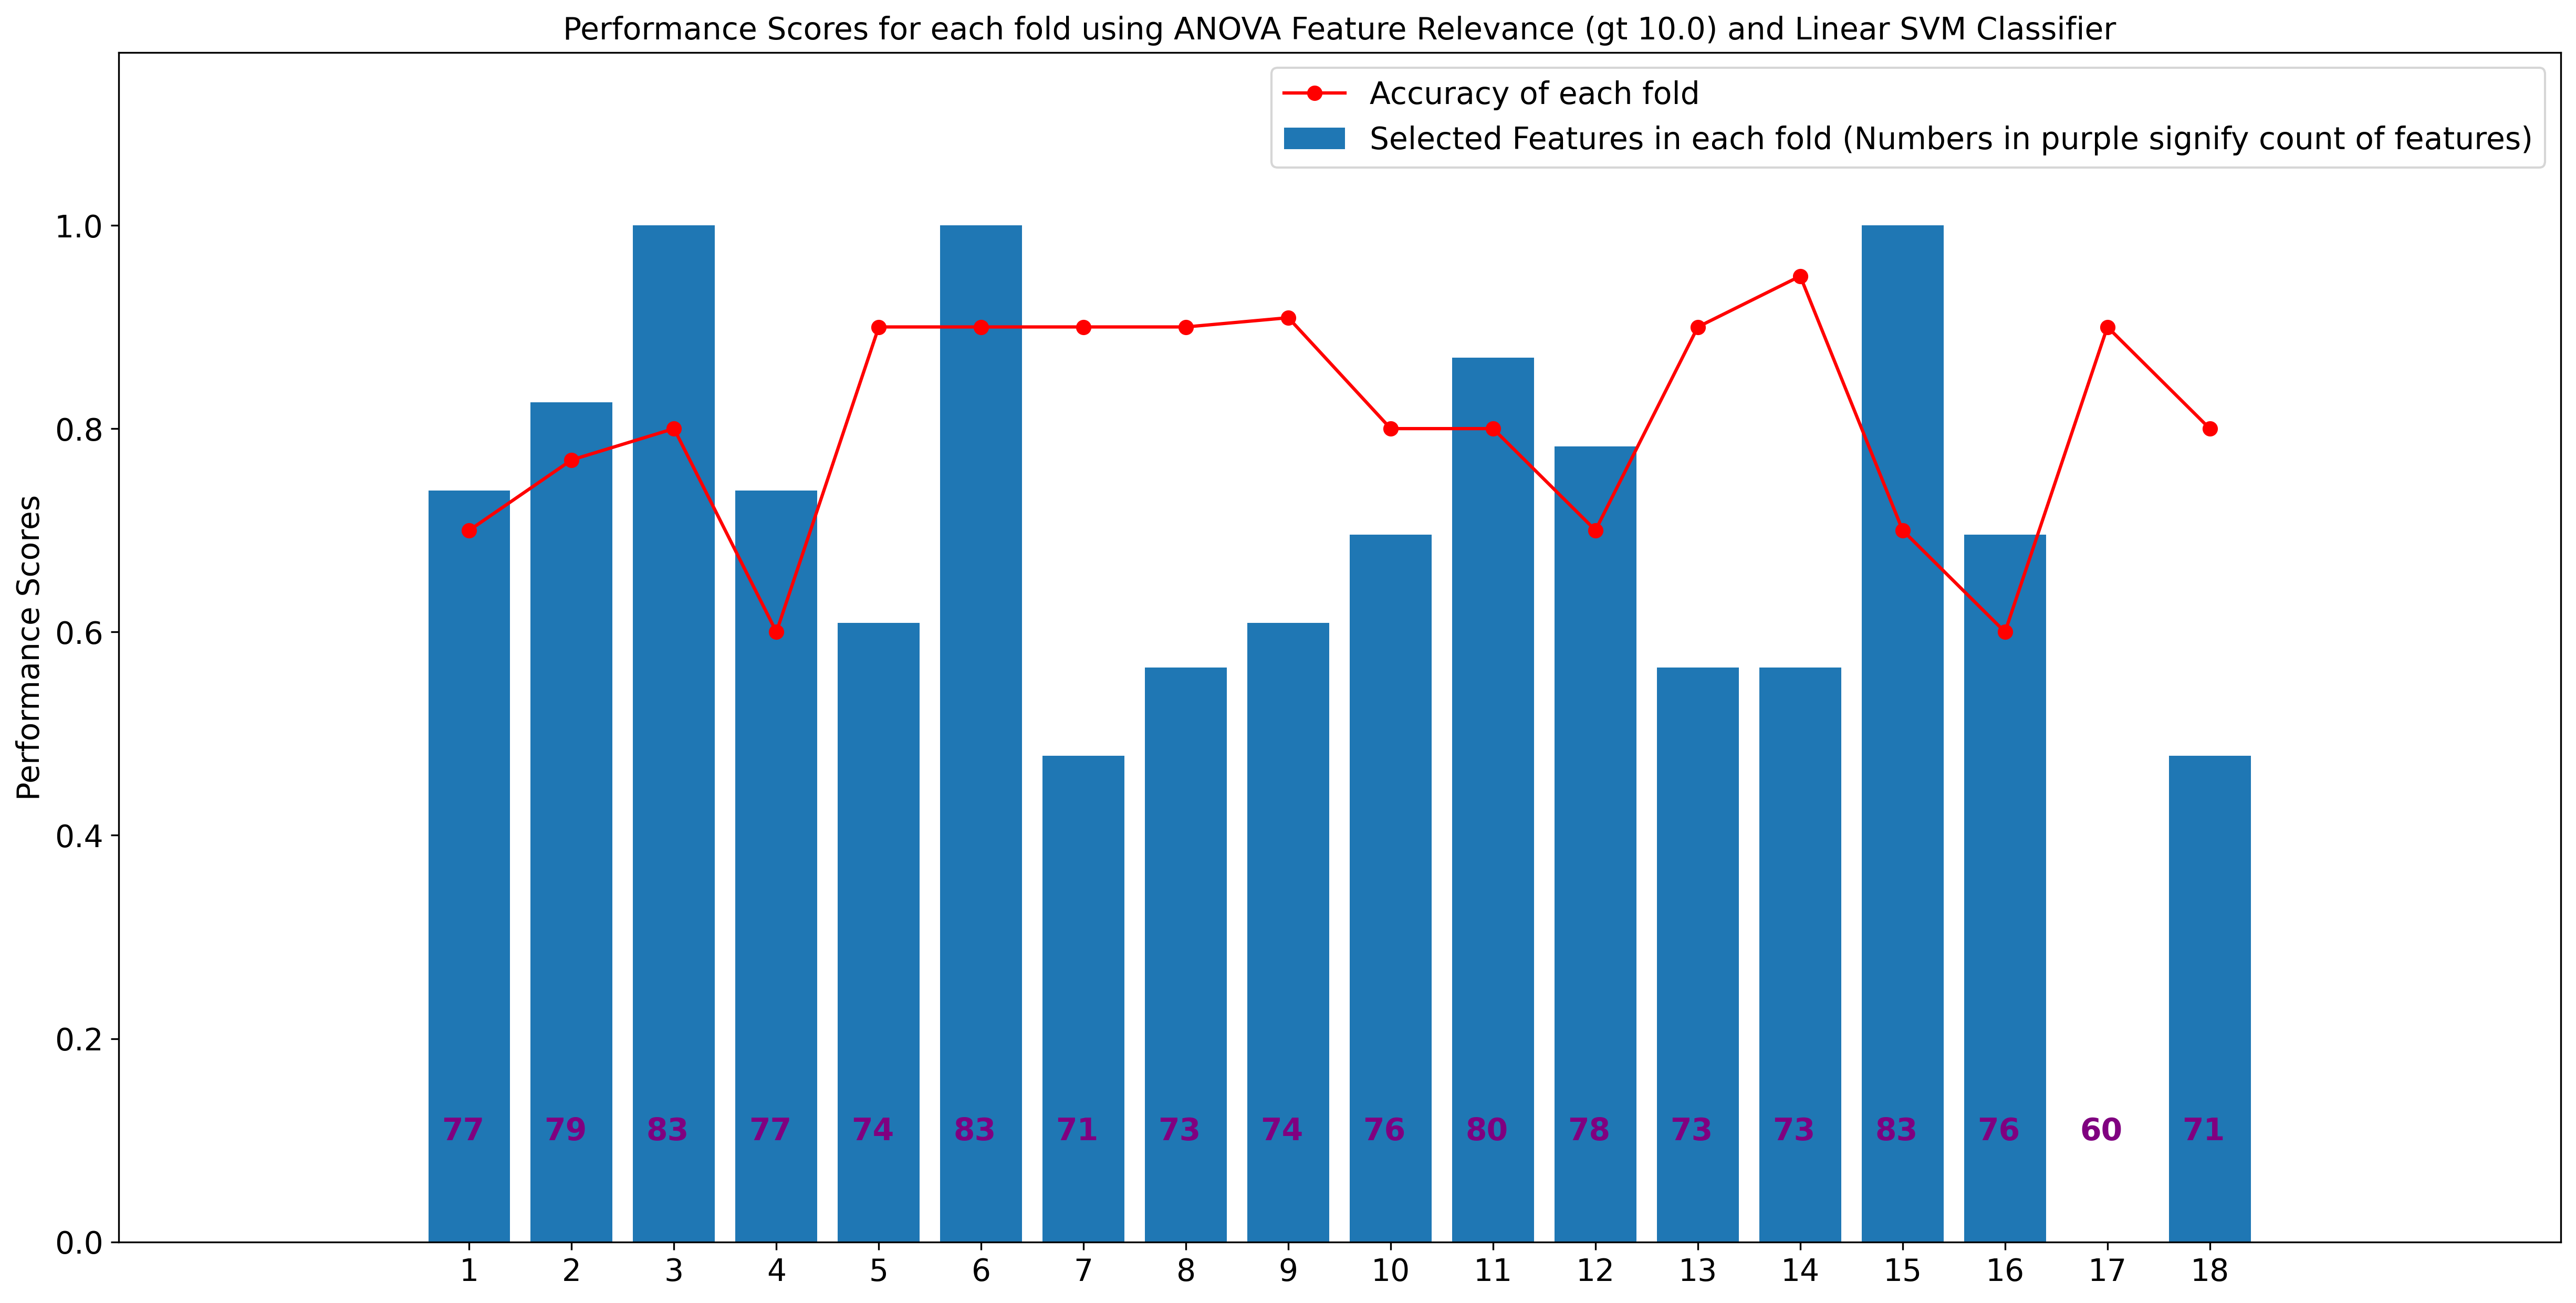

In [51]:
folds = list(range(1, 19))
accuracy_folds = calculate_measures_folds(cm_folds)
accuracy_std = np.std(accuracy_folds)

selected_features_folds = np.array(selected_features_folds)
selected_features_folds_norms = (selected_features_folds-min(selected_features_folds))/(max(selected_features_folds)-min(selected_features_folds))

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.plot(folds, accuracy_folds, 'ro-', label="Accuracy of each fold")
rects2 = ax.bar(folds, selected_features_folds_norms, label="Selected Features in each fold (Numbers in purple signify count of features)")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each fold using ANOVA Feature Relevance (gt 10.0) and Linear SVM Classifier', fontsize=14)
ax.set_xticks(folds) # values
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.17)

for i, v in enumerate(selected_features_folds):
    ax.annotate(v, (i, selected_features_folds_norms[i]), xytext=(i+0.73, 0.1), color='purple', fontweight='bold', fontsize=14)

plt.show()

The above plot marks the accuracy of each fold run and the corresponding number of best features found.
With the exception of number of features in range of 75-77, the plot shows consistent performance in accuracy with the selected features in range of 71-83. Thus, this broader range can be considered optimal for the Linear SVM Classifier.

#### b. ii) Calculation of the mean performance meaures using confusion matrix

In [41]:
# calculate performance scores
accuracy, precision, recall, specificity, sensitivity = calculate_measures(cm_folds)

filter_scores_df.loc['Linear SVM'].iat[0] = accuracy
filter_scores_df.loc['Linear SVM'].iat[1] = accuracy_std
filter_scores_df.loc['Linear SVM'].iat[2] = precision
filter_scores_df.loc['Linear SVM'].iat[3] = recall
filter_scores_df.loc['Linear SVM'].iat[4] = specificity
filter_scores_df.loc['Linear SVM'].iat[5] = sensitivity

#### b. iii) Performance scores across all folds using confusion matrix

In [42]:
filter_scores_df.loc[['Linear SVM']]

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Linear SVM,0.827778,0.106571,0.855856,0.863636,0.771429,0.863636


### Part 2 - Performance Evaluation
### Performance comparison of Classifiers for Filtering Method

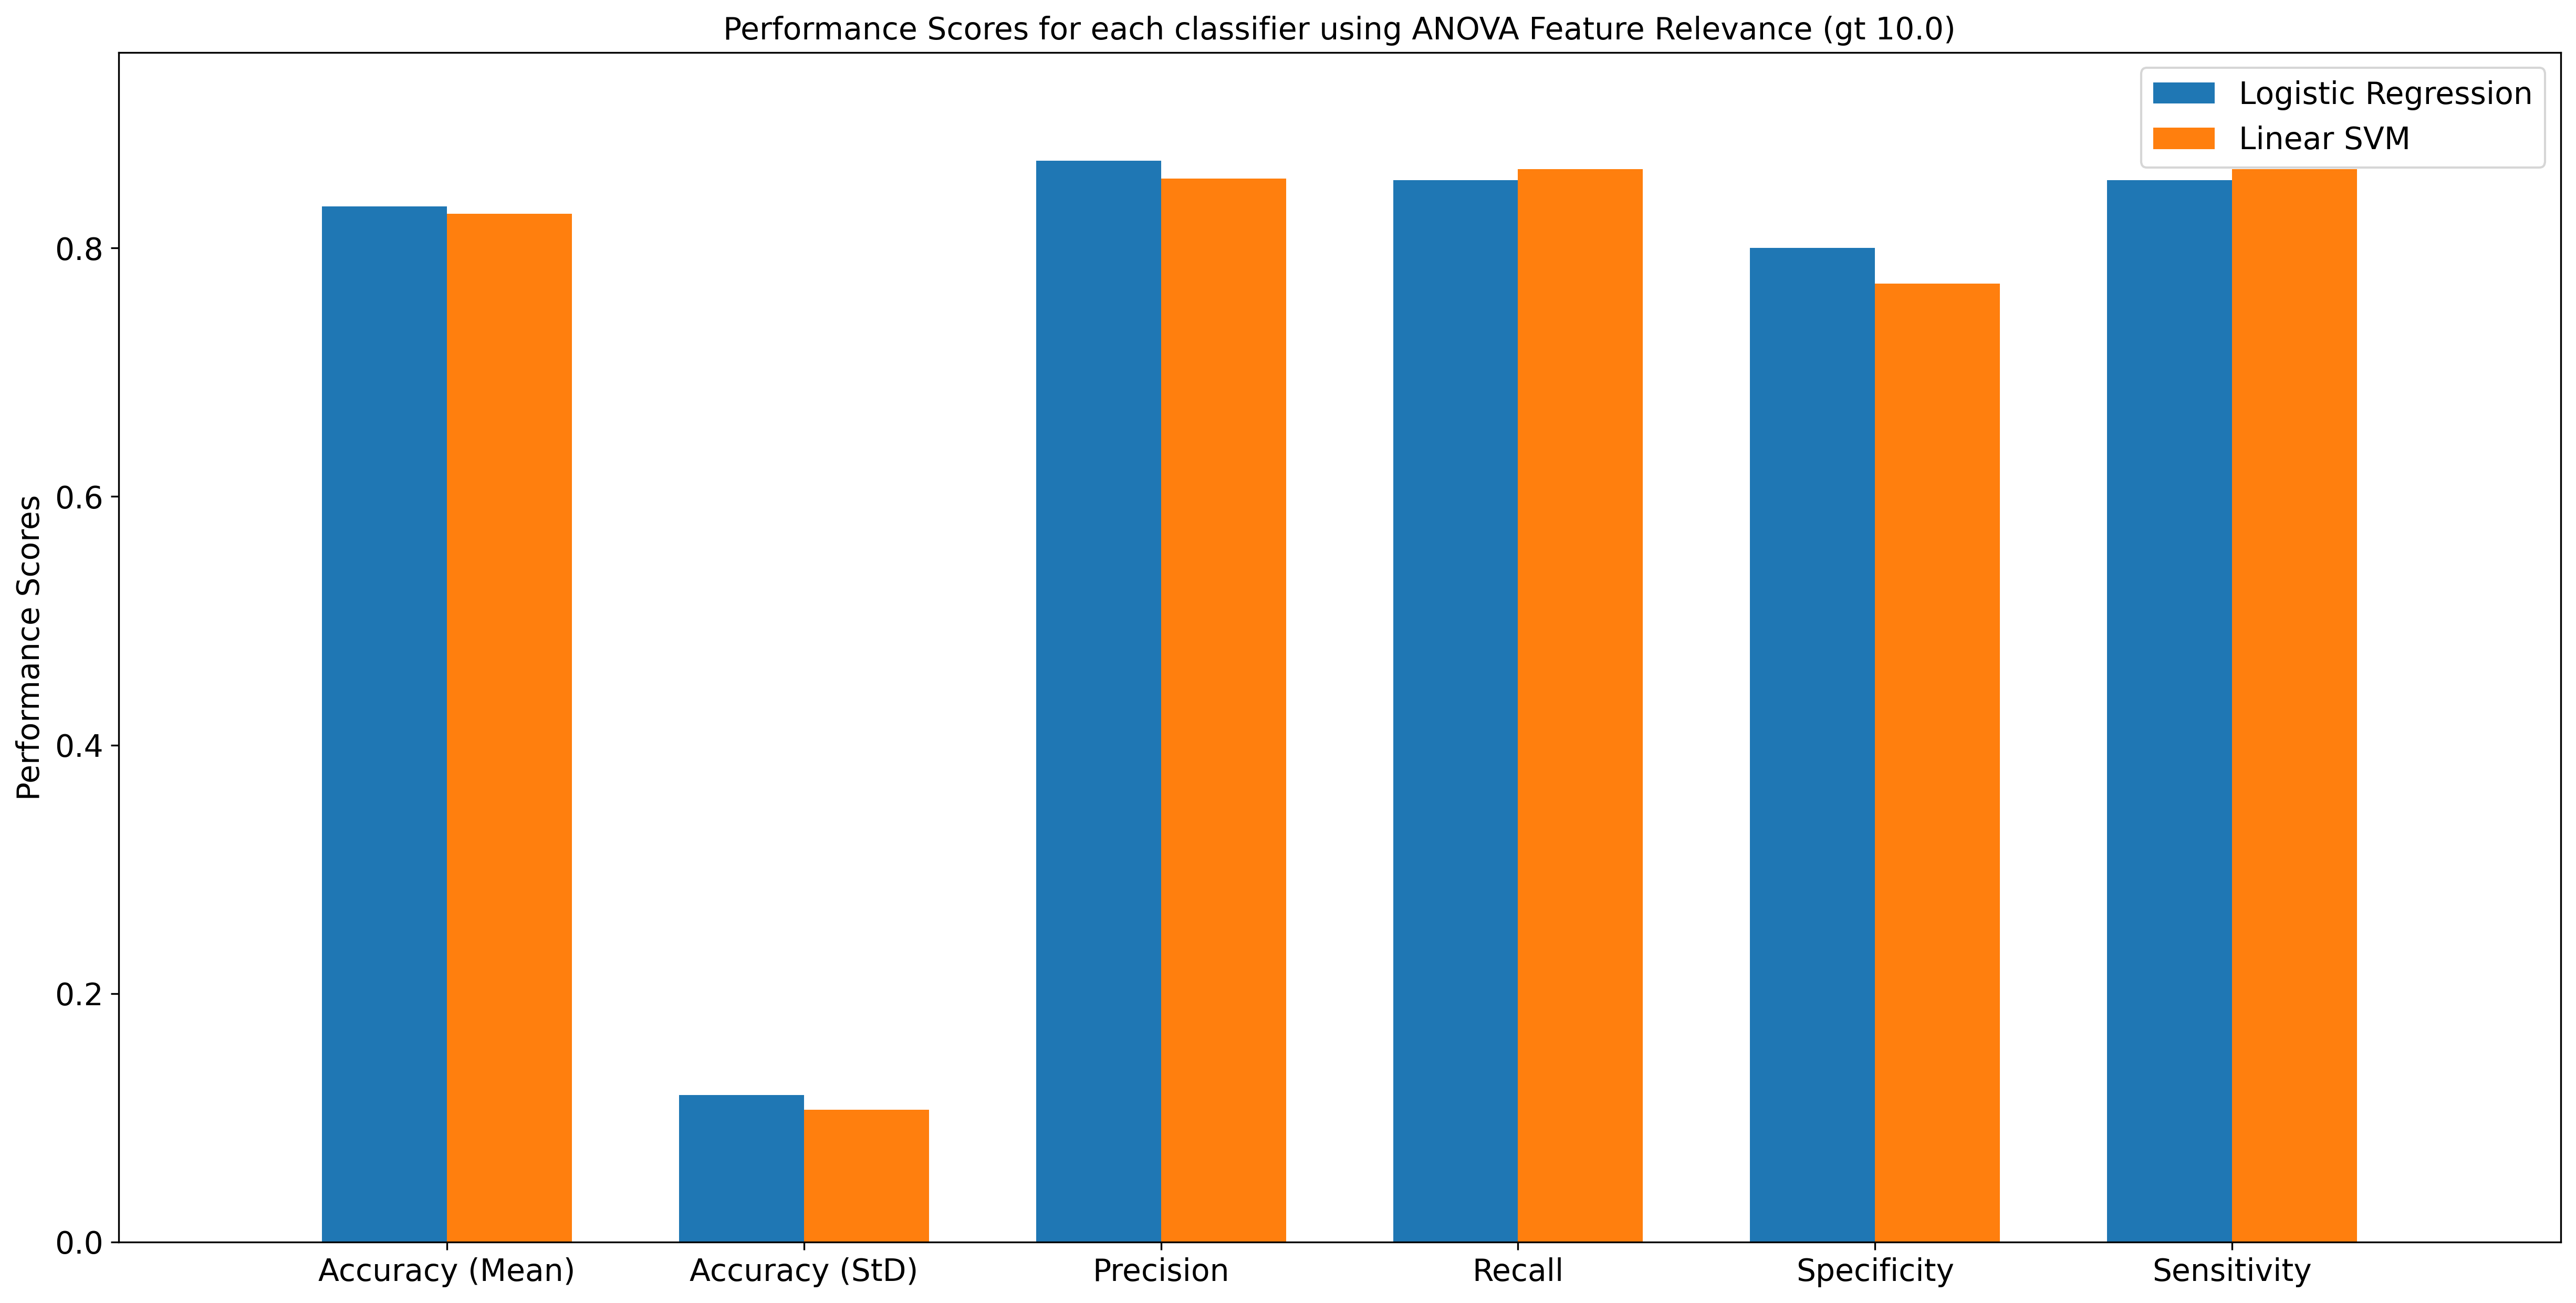

In [43]:
labels = list(filter_scores_df.columns)
lr_scores = filter_scores_df.loc['Logistic Regression'].tolist()
svm_scores = filter_scores_df.loc['Linear SVM'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
rects1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, svm_scores, width, label='Linear SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontsize=14)
ax.set_title('Performance Scores for each classifier using ANOVA Feature Relevance (gt 10.0)', fontsize=14)
ax.set_xticks(x) # values
ax.set_xticklabels(labels) # labels
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.margins(0.1)

plt.show()

The above plot marks 5 mean performance scores - accuracy (mean and std), precision, Recall, Specificity and Sensitivity (same as Recall) across each fold run between the 2 classifiers used for Filtering Method. Based on the results displayed, it is easy to infer that both classifiers performed similarly (with Logistic Regression performing slightly better), but with less accuracy than when the classifiers are run without any feature selection across folds.

## Results

#### Performance measures when no feature selection method is applied

In [44]:
no_feature_selection_scores_df

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.855556,0.116625,0.875,0.890909,0.8,0.890909
Linear SVM,0.872222,0.076257,0.894309,0.916667,0.783333,0.916667


#### Performance measures when Embedded (L1 Regularisation) method is applied

In [45]:
embed_scores_df

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.811111,0.107838,0.858491,0.827273,0.785714,0.827273
Linear SVM,0.805556,0.097024,0.815534,0.84,0.7625,0.84


#### Performance measures when Wrapper (RFE) method is applied

In [46]:
wrapper_scores_df

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.822222,0.13317,0.846939,0.83,0.8125,0.83
Linear SVM,0.844444,0.107509,0.870968,0.9,0.733333,0.9


#### Performance measures when Filtering method is applied

In [47]:
filter_scores_df

,Accuracy (Mean),Accuracy (StD),Precision,Recall,Specificity,Sensitivity
Classifier,,,,,,
Logistic Regression,0.833333,0.118391,0.87037,0.854545,0.8,0.854545
Linear SVM,0.827778,0.106571,0.855856,0.863636,0.771429,0.863636


## Conclusion

While the classifiers trained using feature selection models show less accuracy across folds than when trained with all 432 features, we can note that these values of accuracy and precision show that the models are trained well and when used to test further unseen data, it will deliver similar results as the default models (trained with all features).

All the meaures calculated tend to be closer to 1 and are in vicinity of the default models' performance, determining the models' efficiency and better performance.

While RFE feature selection (Wrapper method) and Filtering method, in general, takes more time to derive the best features to use (due to individual feature elimination process), it gave better results in performance than the lasso regularization (embedded method) for the Linear SVM classifier. 

We also note that the Linear SVM classifier, gives better performance than Logistic Regression classifier, with the exception of Embedded method models.